In [78]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import os
import datetime
import xgboost             as xgb

from boruta                  import BorutaPy
from scipy                   import stats as ss
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [79]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['font.size'] = 25



In [80]:
#Descritivo das variaveis
#We will study the sales data of one of the largest retailers in the world. Let's figure out what factors influence its revenue. Can factors such as air temperature and fuel cost influence the success of a huge company along with the purchasing power index and seasonal discounts? And how does machine learning minimize costs and increase economic impact?

#The data contains the following columns:

# - Store: Store number
# - Date: Sales week start date
# - Weekly_Sales: Sales
# - Holiday_Flag: Mark on the presence or absence of a holiday
# - Temperature: Air temperature in the region
# - Fuel_Price: Fuel cost in the region
# - CPI: Consumer price index
# - Unemployment: Unemployment rate

In [81]:
# Opening CSV
df = pd.read_csv('https://raw.githubusercontent.com/pedroesoares/Walmart-Sales/main/Walmart_sales.csv')
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [82]:
#Descrição estatística dos dados
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [83]:
#Df Types and Df is na
df.sum().isna()

Store           False
Date            False
Weekly_Sales    False
Holiday_Flag    False
Temperature     False
Fuel_Price      False
CPI             False
Unemployment    False
dtype: bool

In [84]:
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [85]:
num_attributes = df.select_dtypes(include=['int64', 'float64'])
num_attributes.drop('Store', axis=1, inplace=True)


In [86]:
# Dispersion - desvio padrão, min, max, range, skew and kurtosis

d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenar dados

metricas = pd.concat( [d2, d3, d4, d1, d5, d6] ).T.reset_index()
metricas.columns = ['Attributes', 'Min', 'Max', 'Median', 'std', 'Skew', 'Kurtosis']

In [87]:
metricas

,Attributes,Min,Max,Median,std,Skew,Kurtosis
0,Weekly_Sales,209986.250,3.818686e+06,3.608700e+06,564322.769020,0.668362,0.053141
1,Holiday_Flag,0.000,1.000000e+00,1.000000e+00,0.255029,3.373499,9.383410
2,Temperature,-2.060,1.001400e+02,1.022000e+02,18.443500,-0.336768,-0.612801
3,Fuel_Price,2.472,4.468000e+00,1.996000e+00,0.458984,-0.096158,-1.177378
4,CPI,126.064,2.272328e+02,1.011688e+02,39.353654,0.063492,-1.839813
5,Unemployment,3.879,1.431300e+01,1.043400e+01,1.875739,1.188144,2.639712


In [88]:
df.rename(columns={'Weekly_Sales':'Sales'},inplace=True)

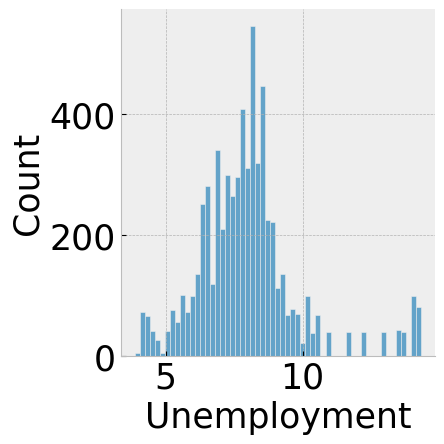

In [89]:

#sns.displot(df['Weekly_Sales']);
#sns.displot(df['Temperature']);
#sns.displot(df['Fuel_Price']);
#sns.displot(df['CPI']);
sns.displot(df['Unemployment']);

<Axes: xlabel='Holiday_Flag', ylabel='Sales'>

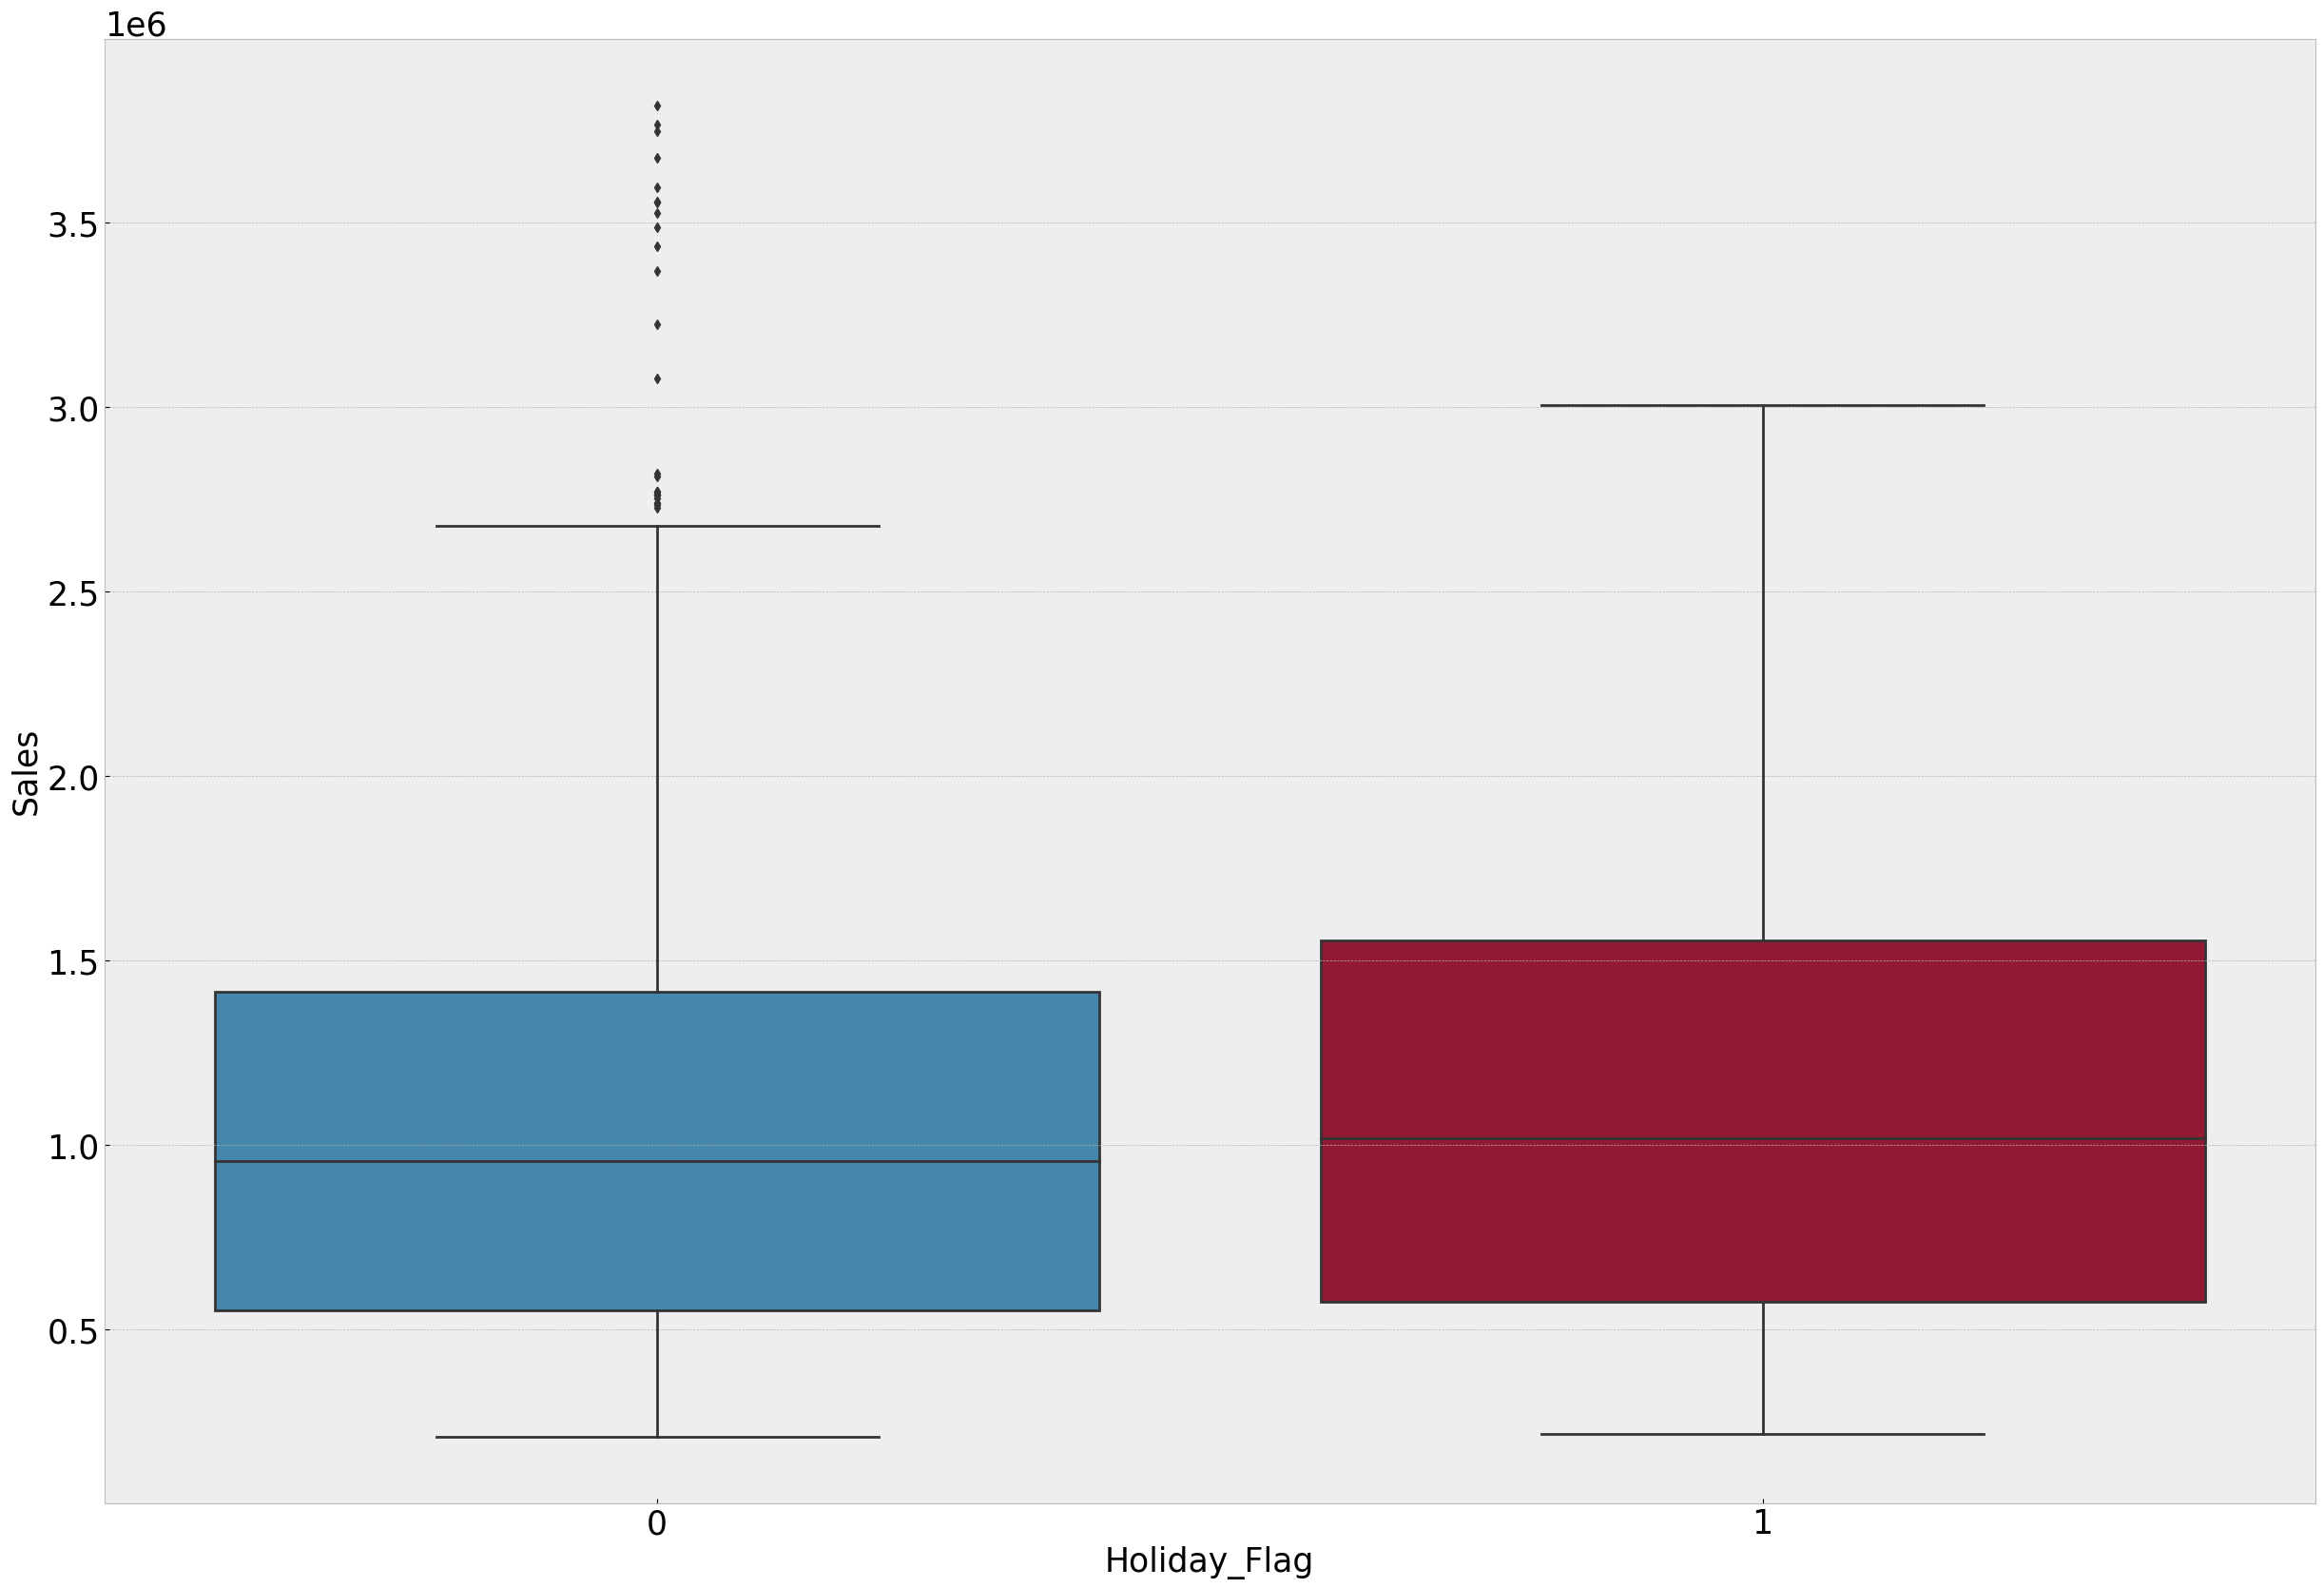

In [90]:
aux1 = df[(df['Sales'] > 0)]

sns.boxplot(x='Holiday_Flag', y='Sales', data=aux1 )

<Axes: xlabel='Date', ylabel='Sales'>

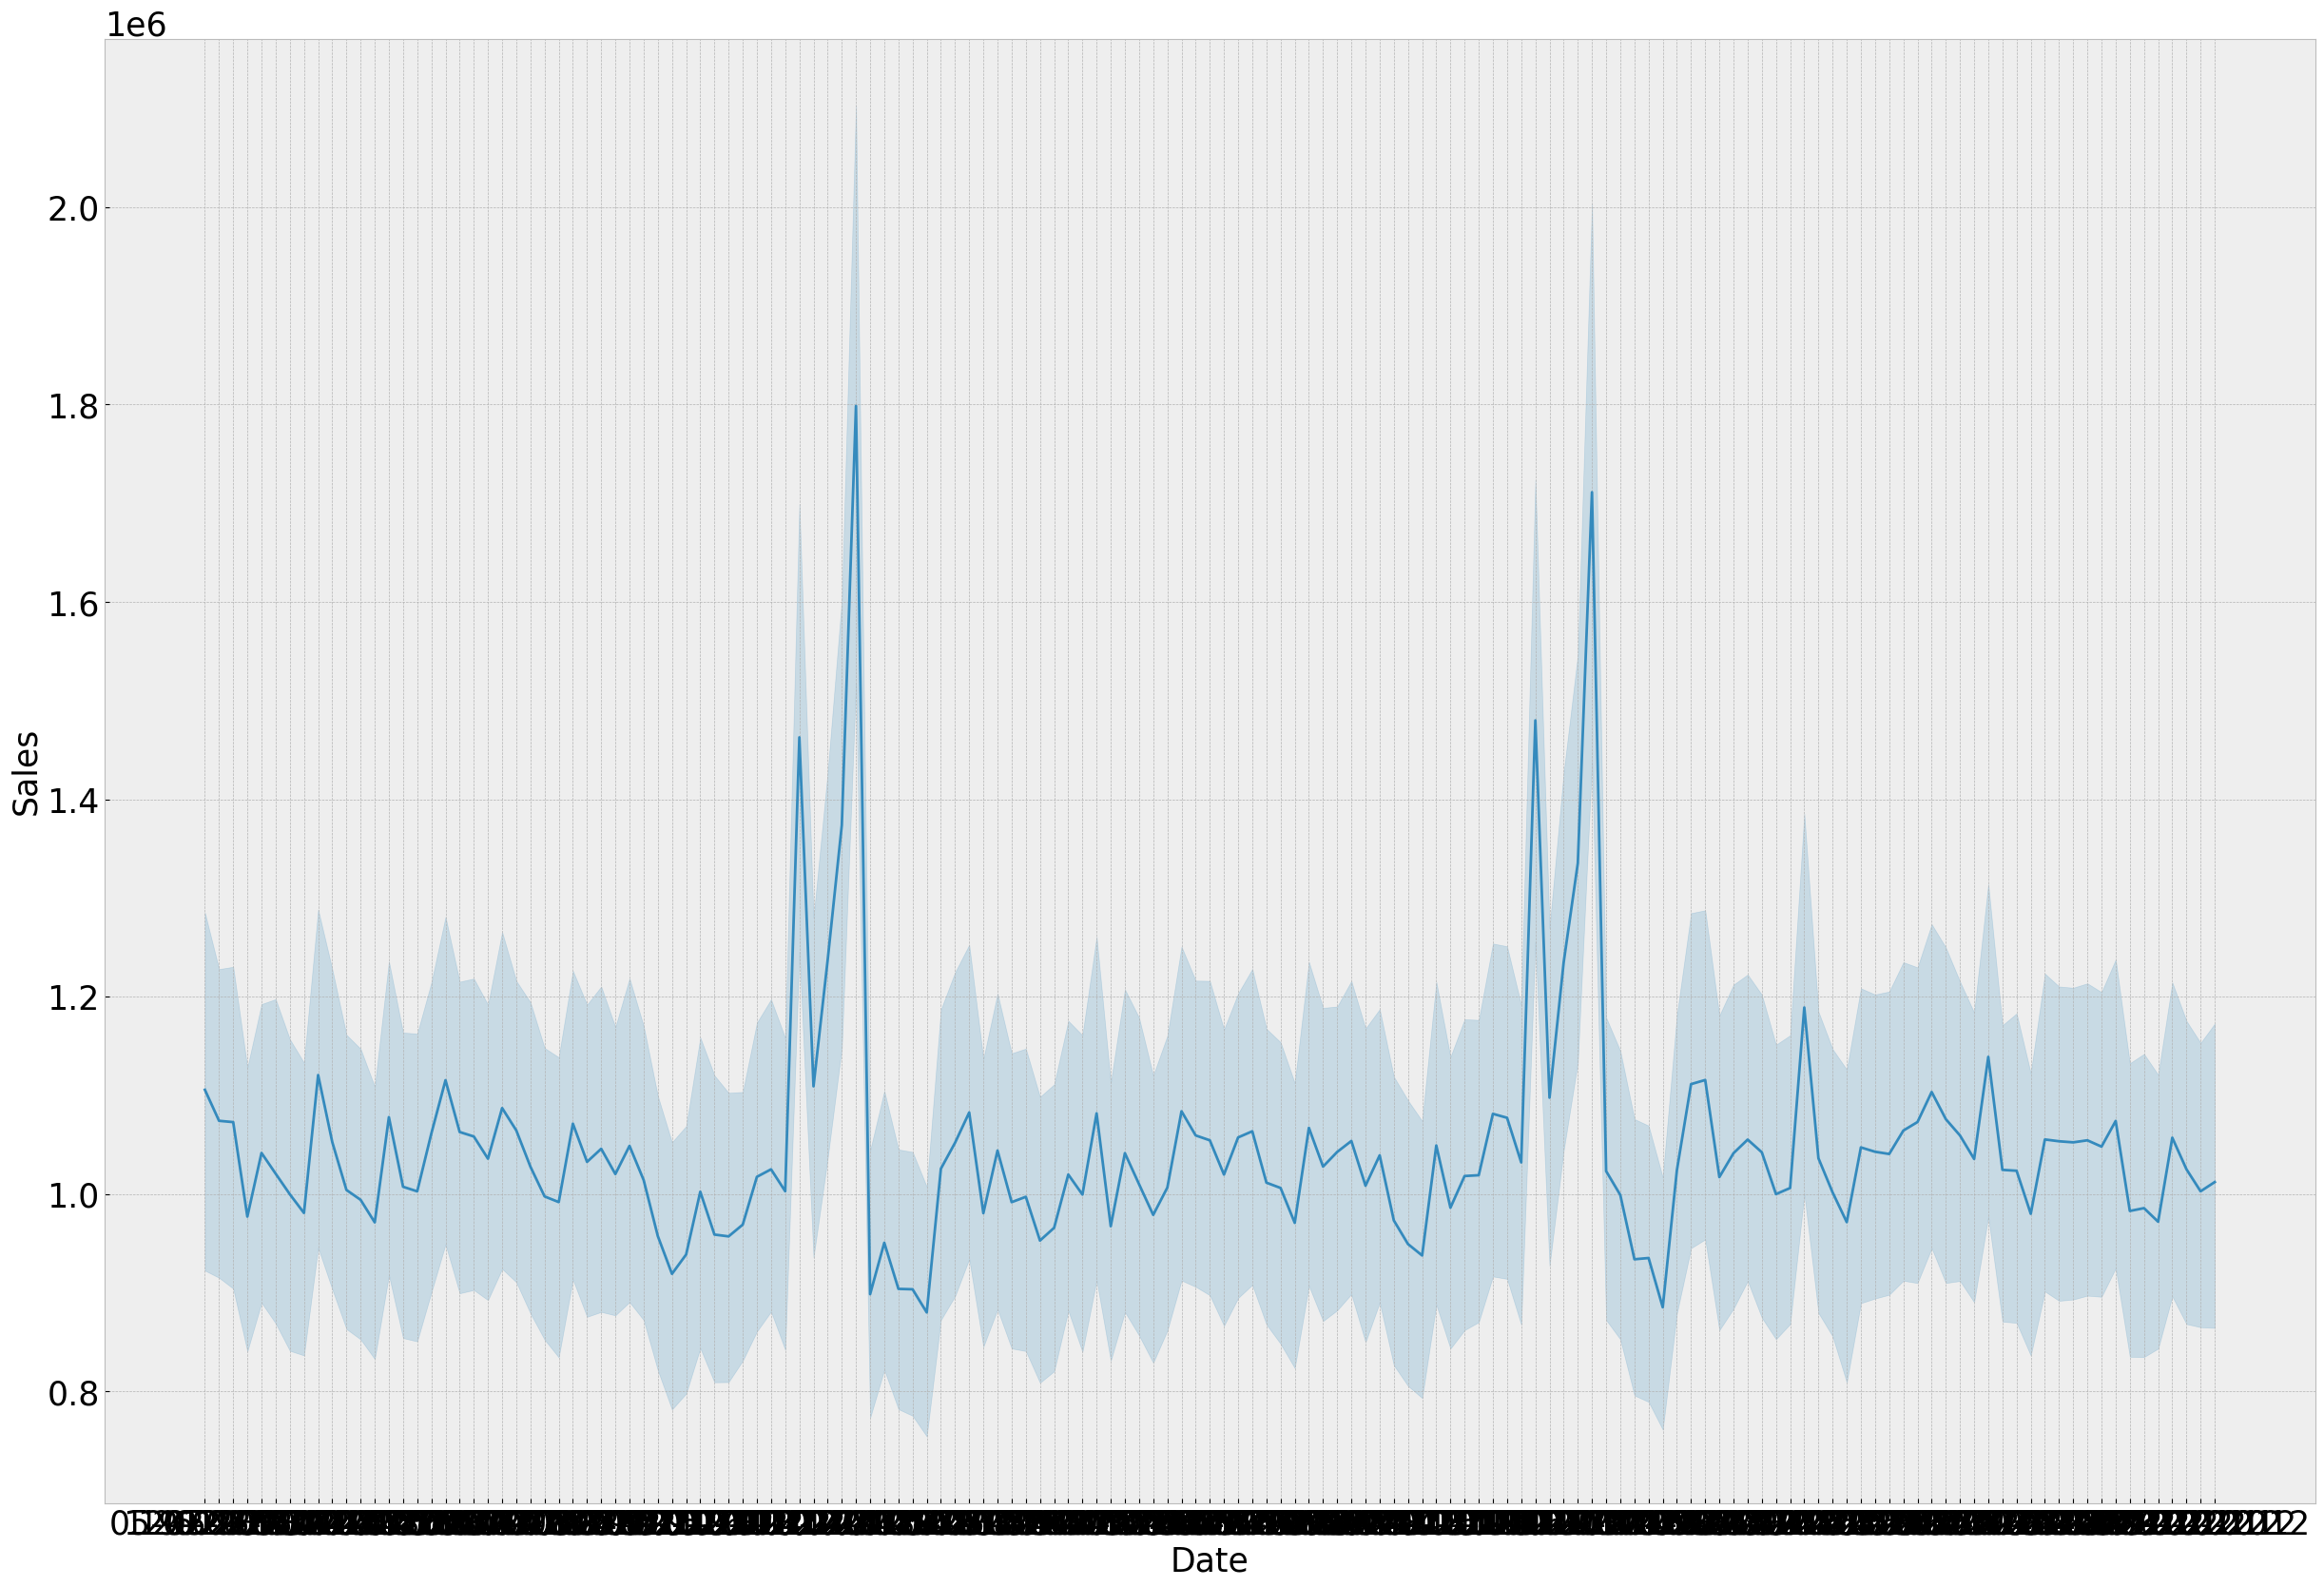

In [91]:
sns.lineplot(data=aux1, x='Date', y='Sales')


In [92]:
#FEATURE ENGINEERING
df2 = df
df2.sample().T

,5627
Store,40
Date,21-01-2011
Sales,764014.75
Holiday_Flag,0
Temperature,14.64
Fuel_Price,3.232
CPI,133.028516
Unemployment,5.114


In [93]:
df2['Date'] = pd.to_datetime(df2['Date'], format = '%d-%m-%Y')

In [94]:
#Extrair informações de Datas
#Ano
df2['Year'] = df2['Date'].dt.year

#Mês
df2['Month'] = df2['Date'].dt.month

#Semana
#df2['Week'] = df2['Date'].dt.weekofyear

#Dia
df2['Day'] = df2['Date'].dt.day

### MONTAGEM DE HIPOTESES
1. Lojas vendem mais em Feriados do que dias normais
2. Lojas com maior taxa de desemprego deveriam vender menos
3. Lojas com preço da Gasolina mais barato deveriam vender mais
4. Lojas diferentes devem ter perfis de vendas diferentes
5. Momentos de maior CPI (Consumer Price Index) as vendas tender a ser menor

## 2.0 Análise Exploratória dos dados

### 2.1 Análise Univariada

In [95]:
num_attributes = df2[['Sales','Temperature','Fuel_Price','CPI','Unemployment']]
cat_attributes = df2[['Store','Date','Holiday_Flag','Year','Month','Day']]


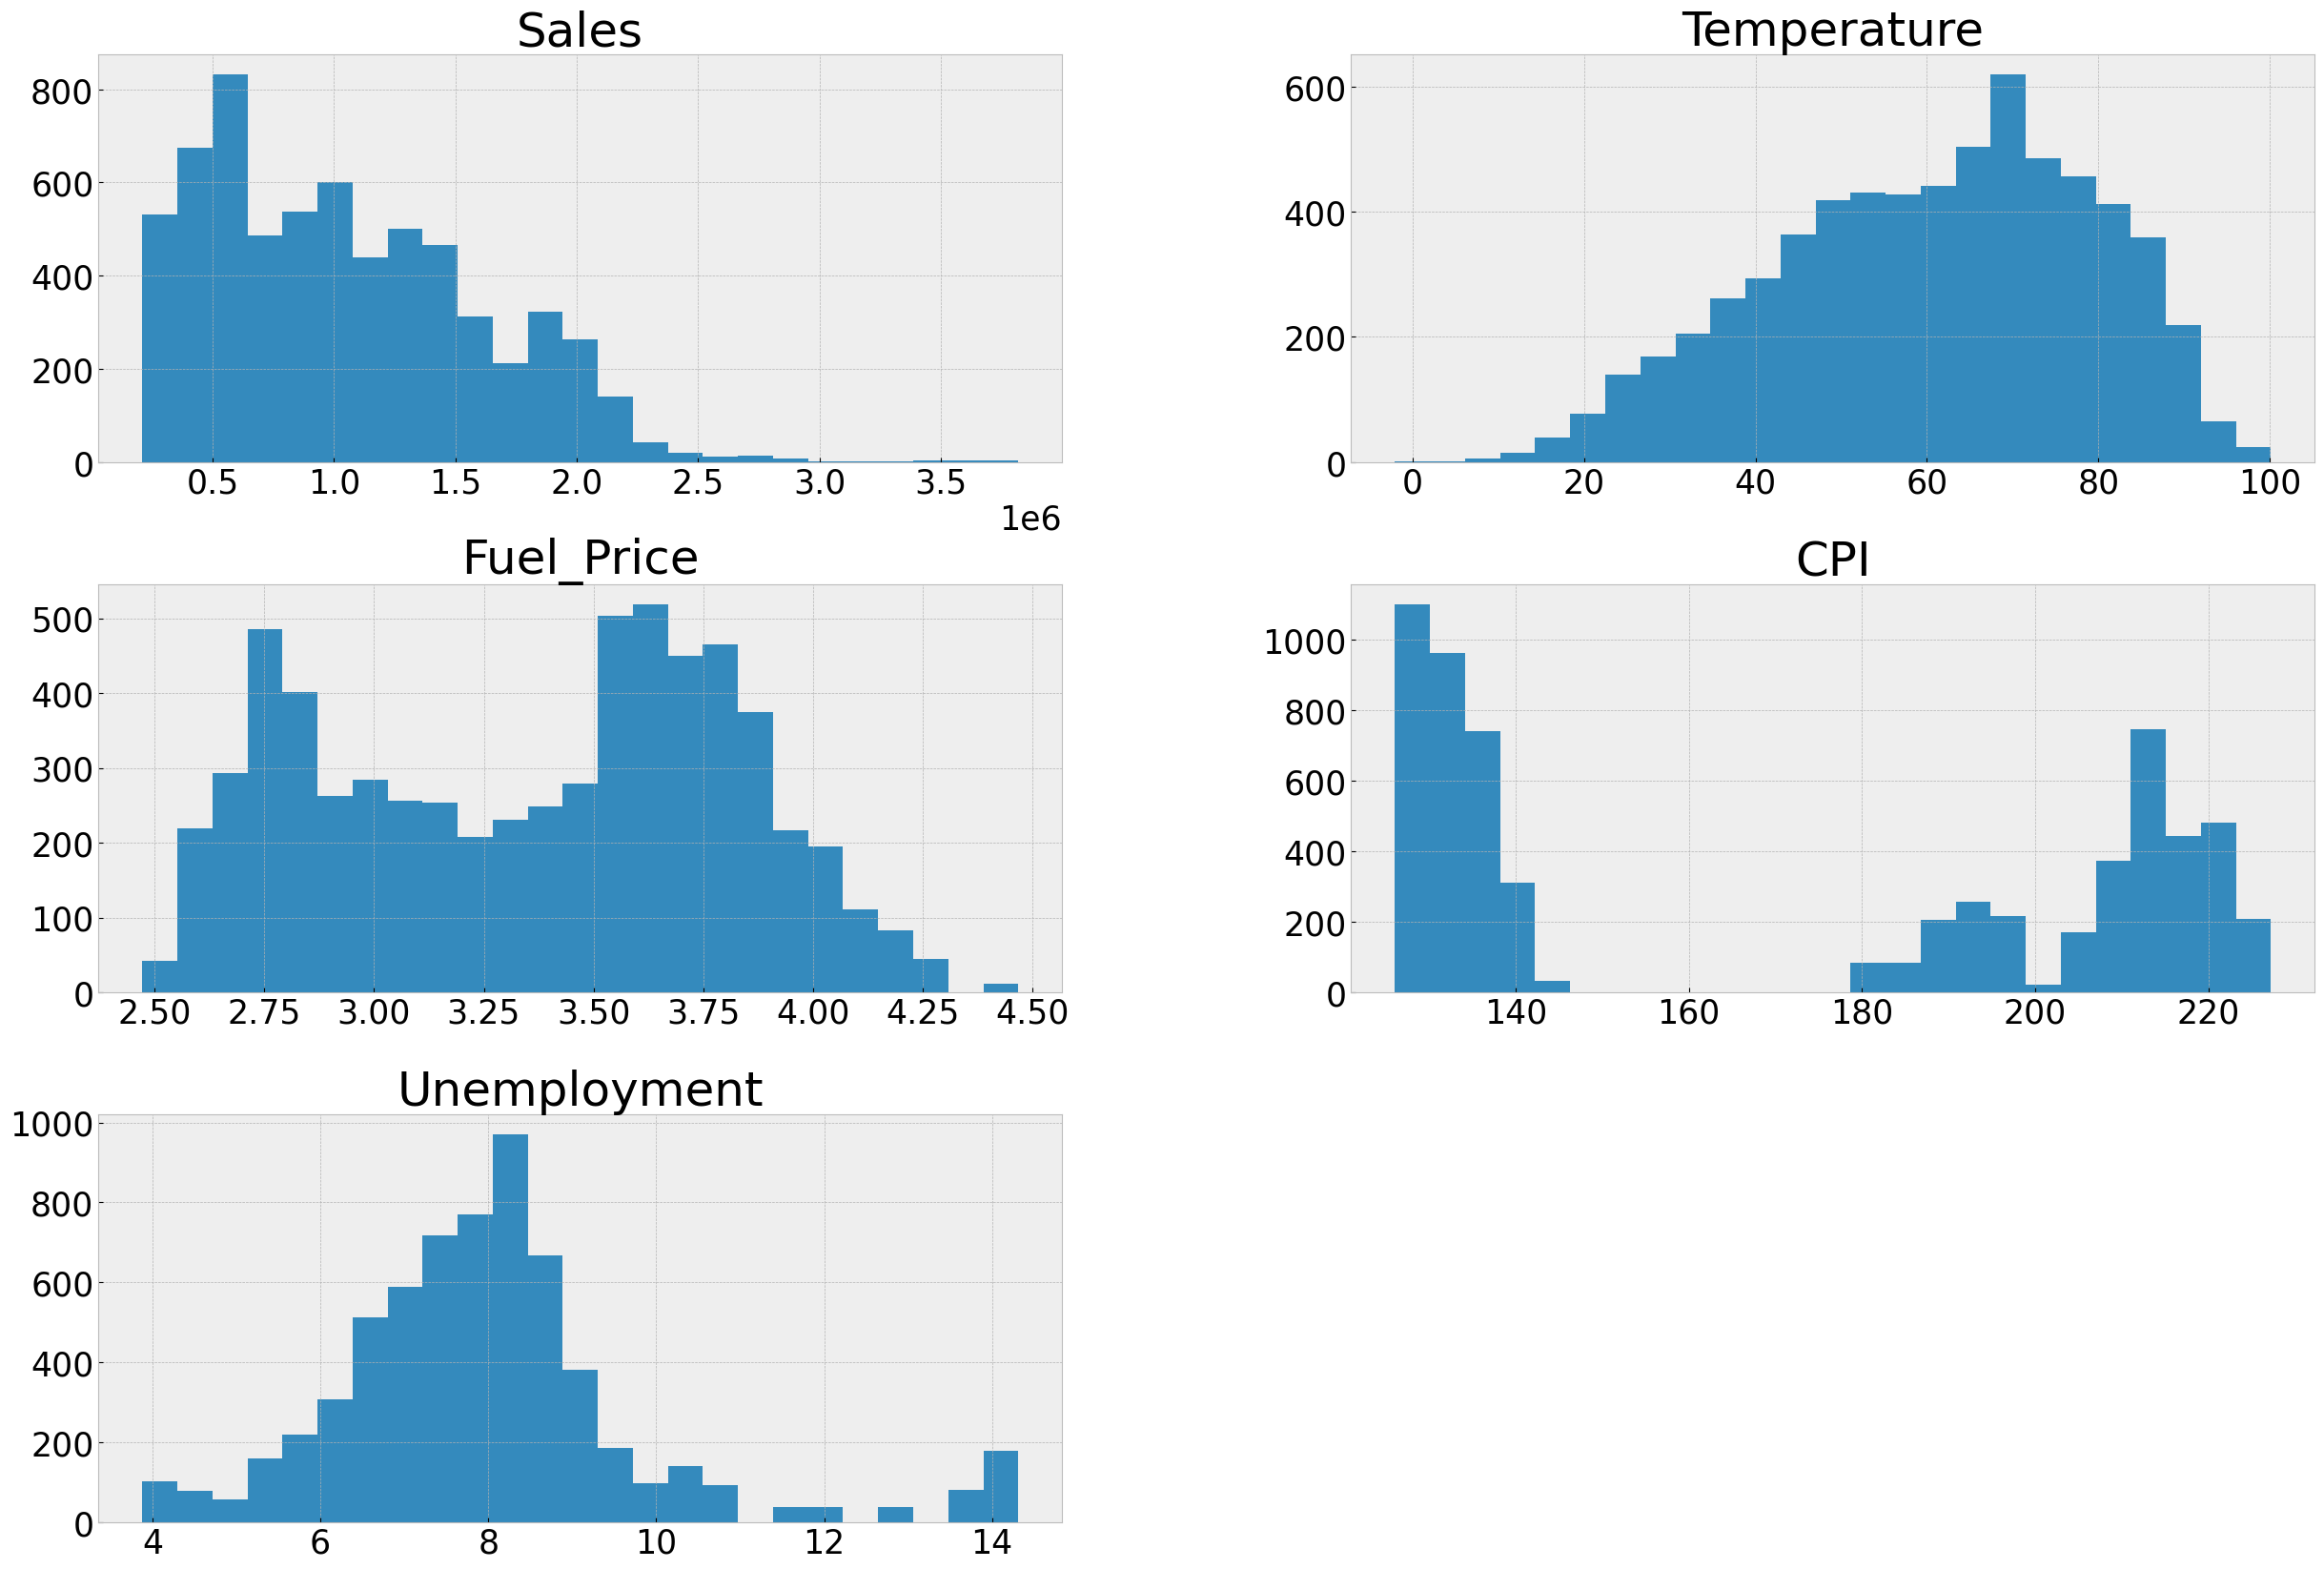

In [96]:
num_attributes.hist(bins=25);

In [97]:
#Lojas vendem mais em Feriados do que dias normais

### 2.2 Análise Bivariada

<Axes: xlabel='Store', ylabel='CPI'>

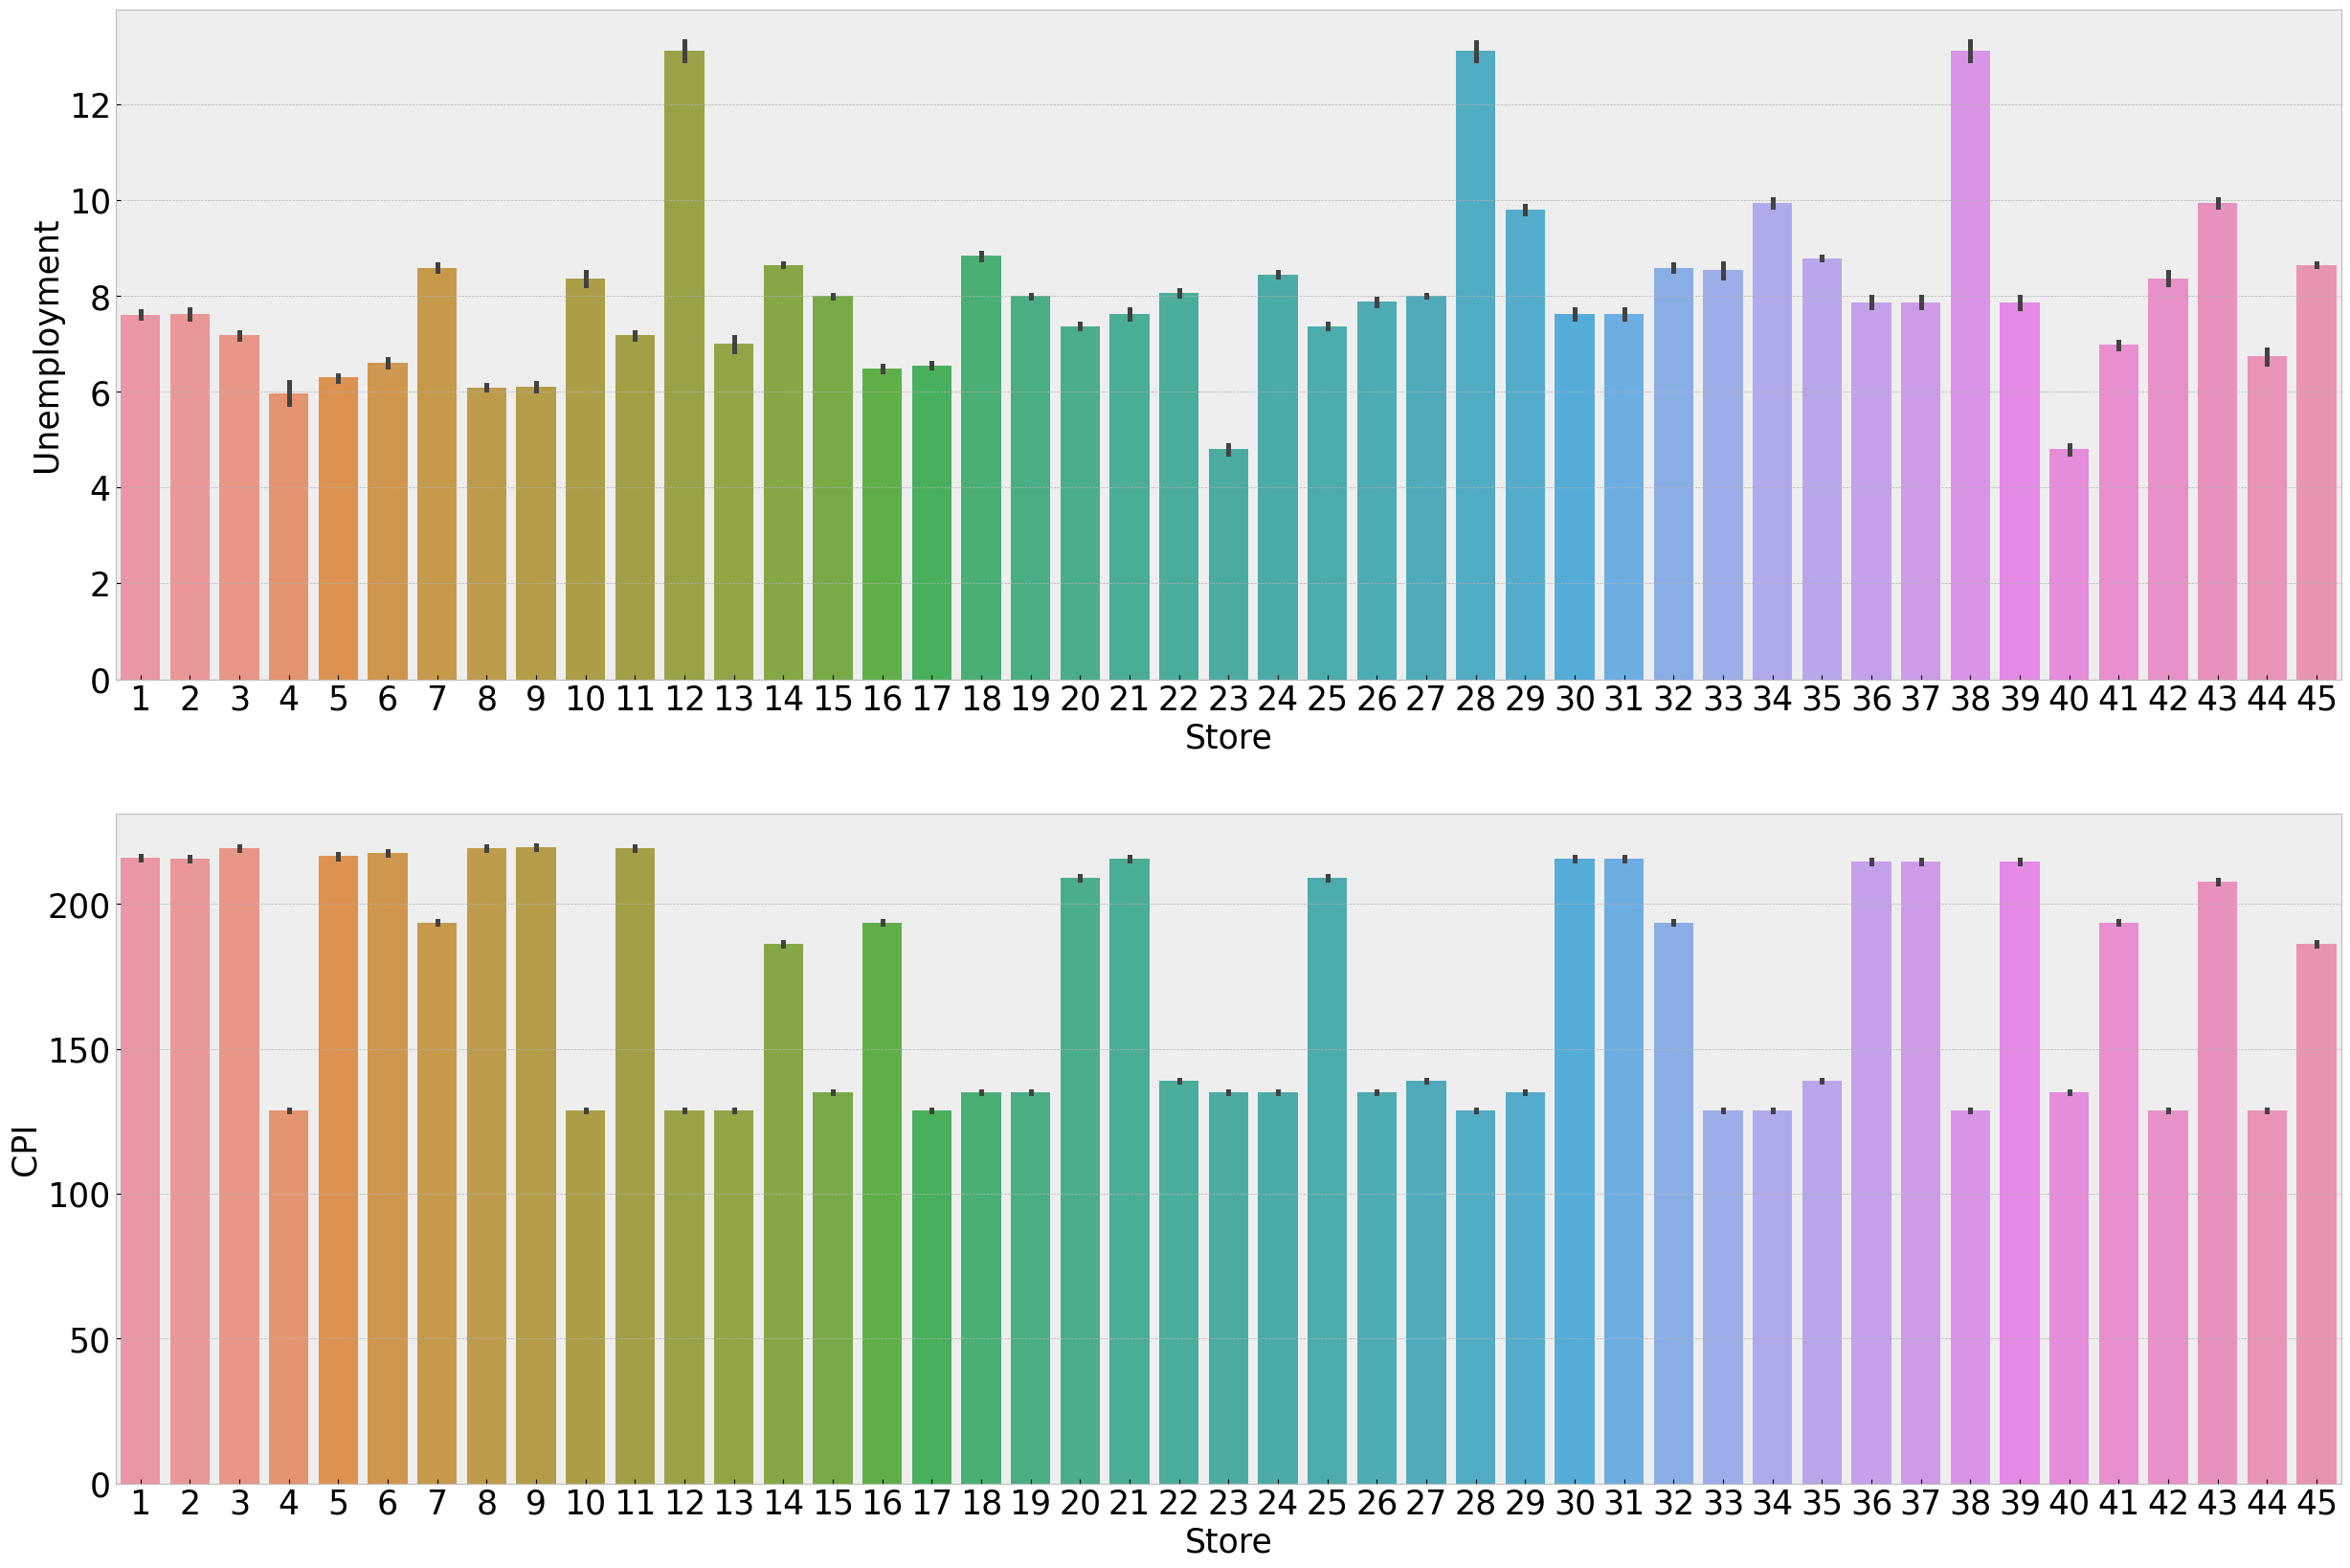

In [98]:
plt.subplot(2,1,1)
#df2[df2['Store'] == 11]
sns.barplot(x='Store', y='Unemployment', data= df)

plt.subplot(2,1,2)
#df2[df2['Store'] == 11]
sns.barplot(x='Store', y='CPI', data= df)

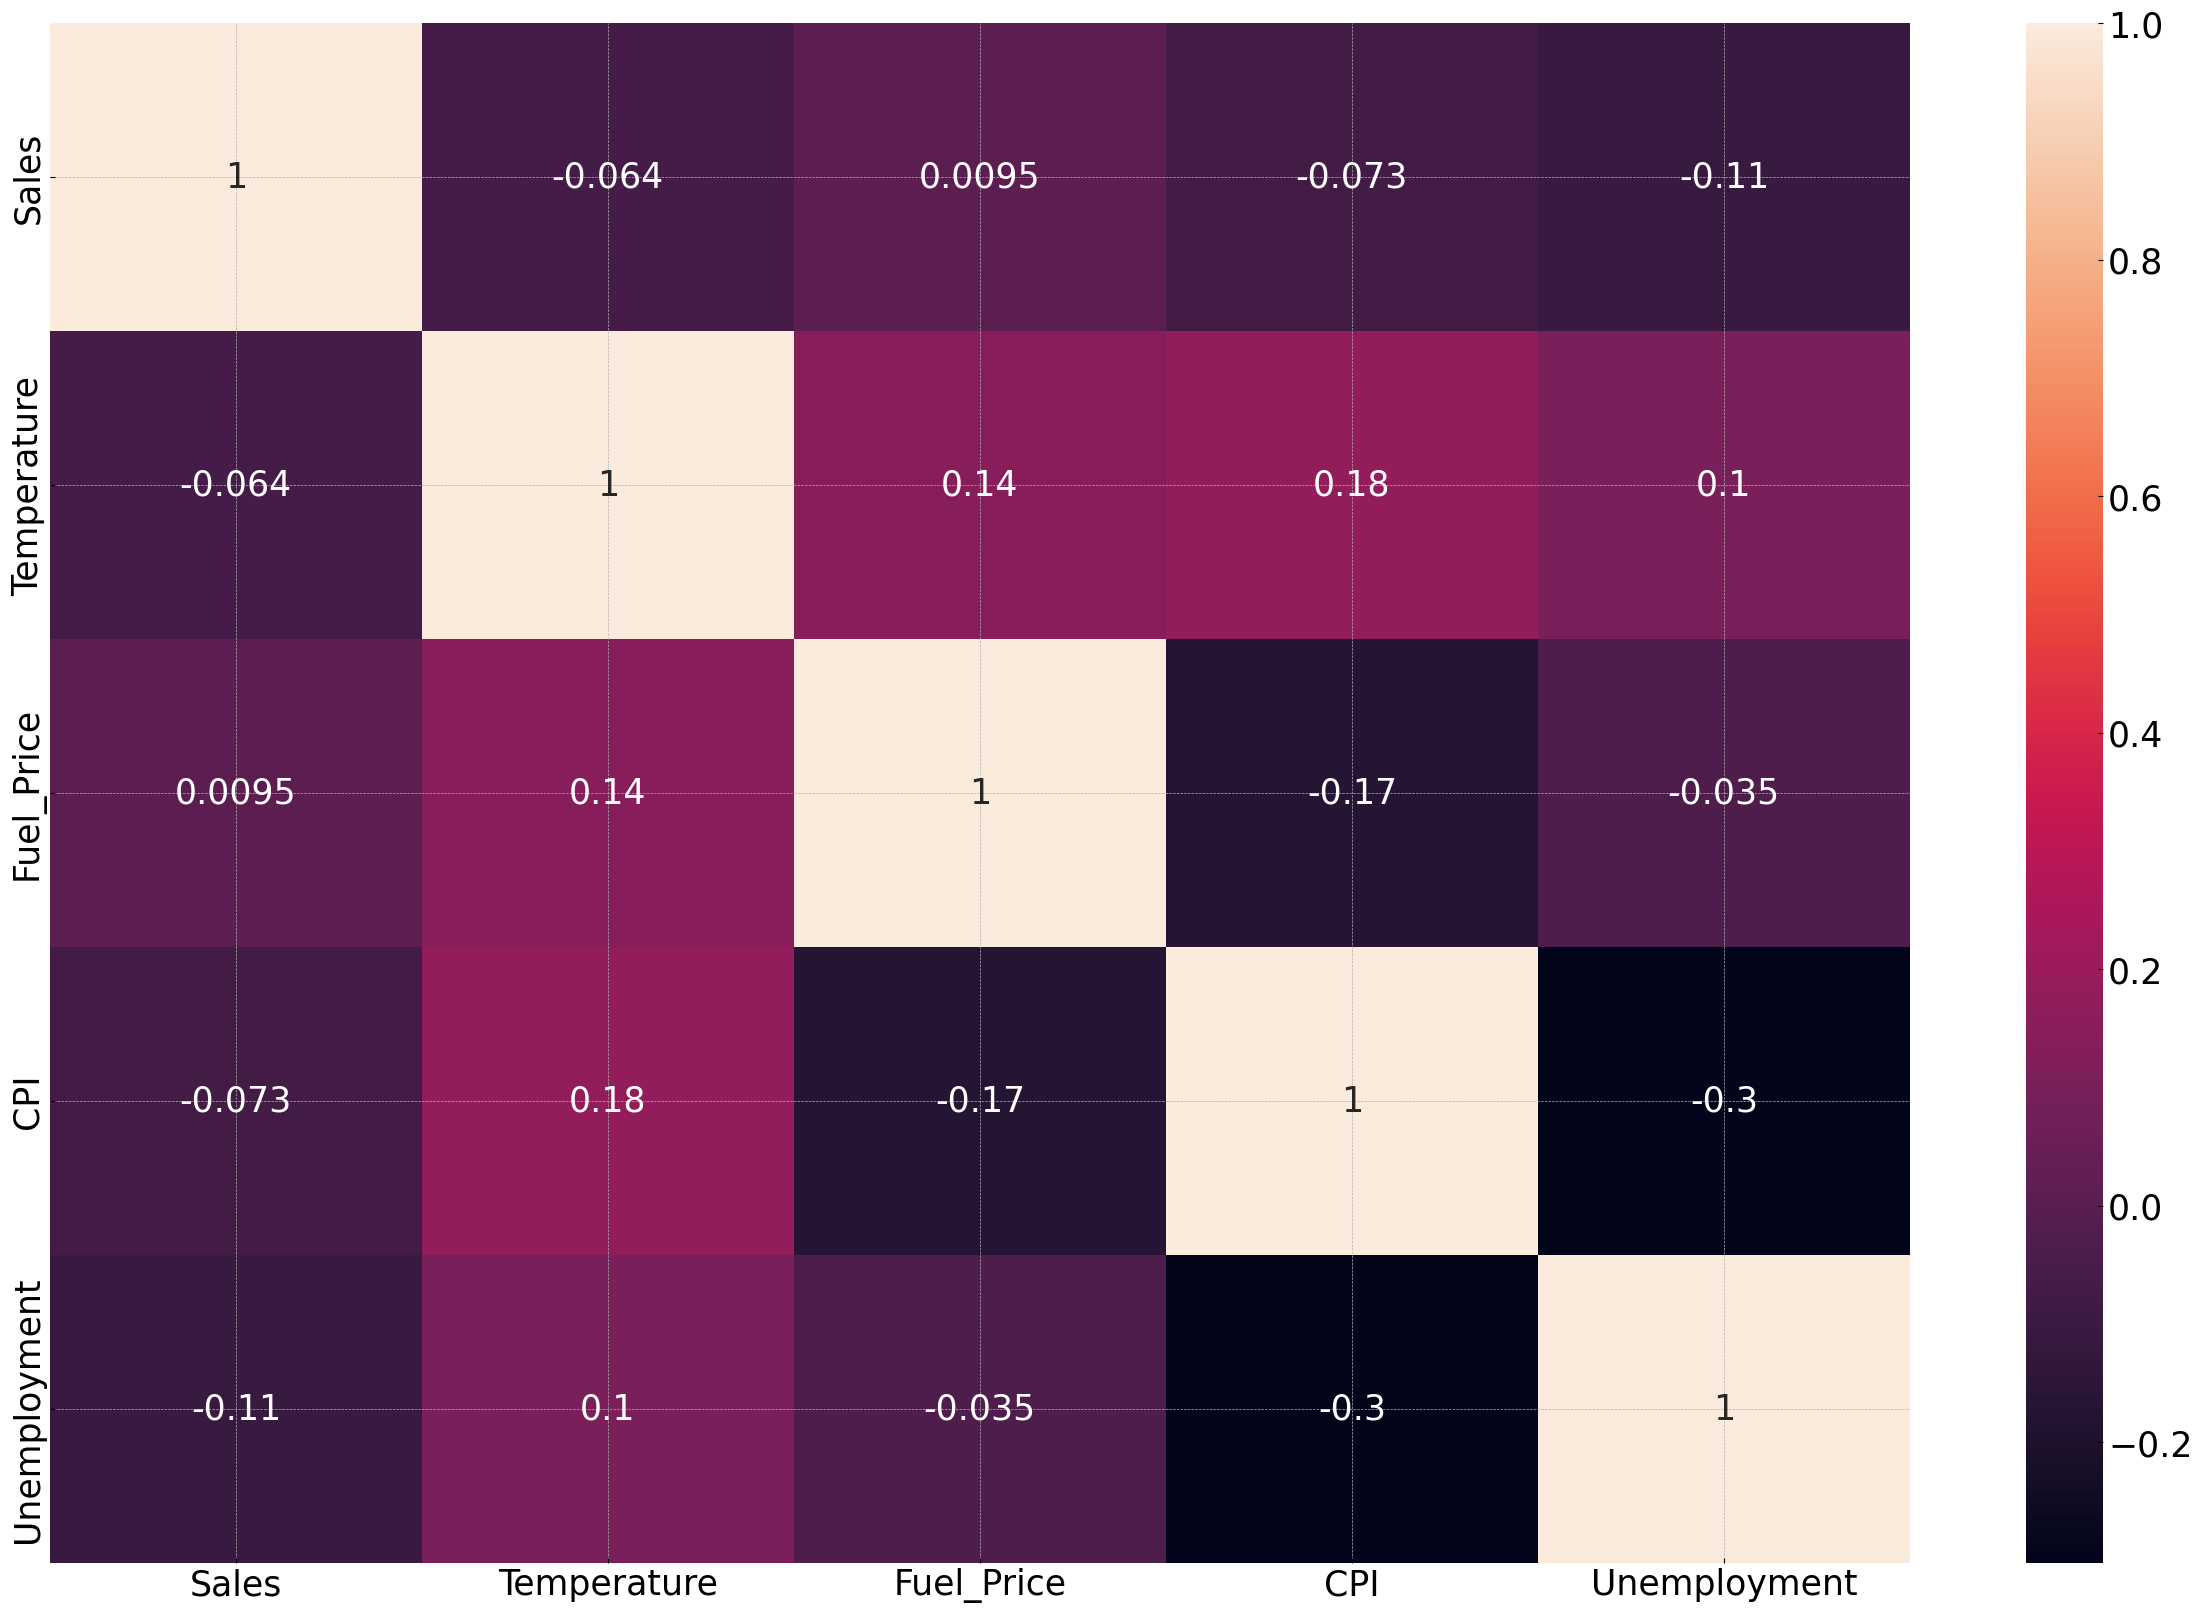

In [99]:
corr = num_attributes.corr(method='pearson')
sns.heatmap(corr, annot= True);

## 5 PREPARAÇÃO DOS DADOS

### 5.1 RESCALING

In [100]:
mms = MinMaxScaler()
df2 = df


In [101]:
df2['Temperature'] = mms.fit_transform(df2[['Temperature']].values)
df2['Fuel_Price'] = mms.fit_transform(df2[['Fuel_Price']].values)
df2['CPI'] = mms.fit_transform(df2[['CPI']].values)
df2['Unemployment'] = mms.fit_transform(df2[['Unemployment']].values)
df2['Year'] = mms.fit_transform(df2[['Year']].values)

In [102]:
#mms.fit_transform(df2[['Temperature']].values)

In [103]:
df2['Sales 2'] = np.log1p(df2['Sales'])

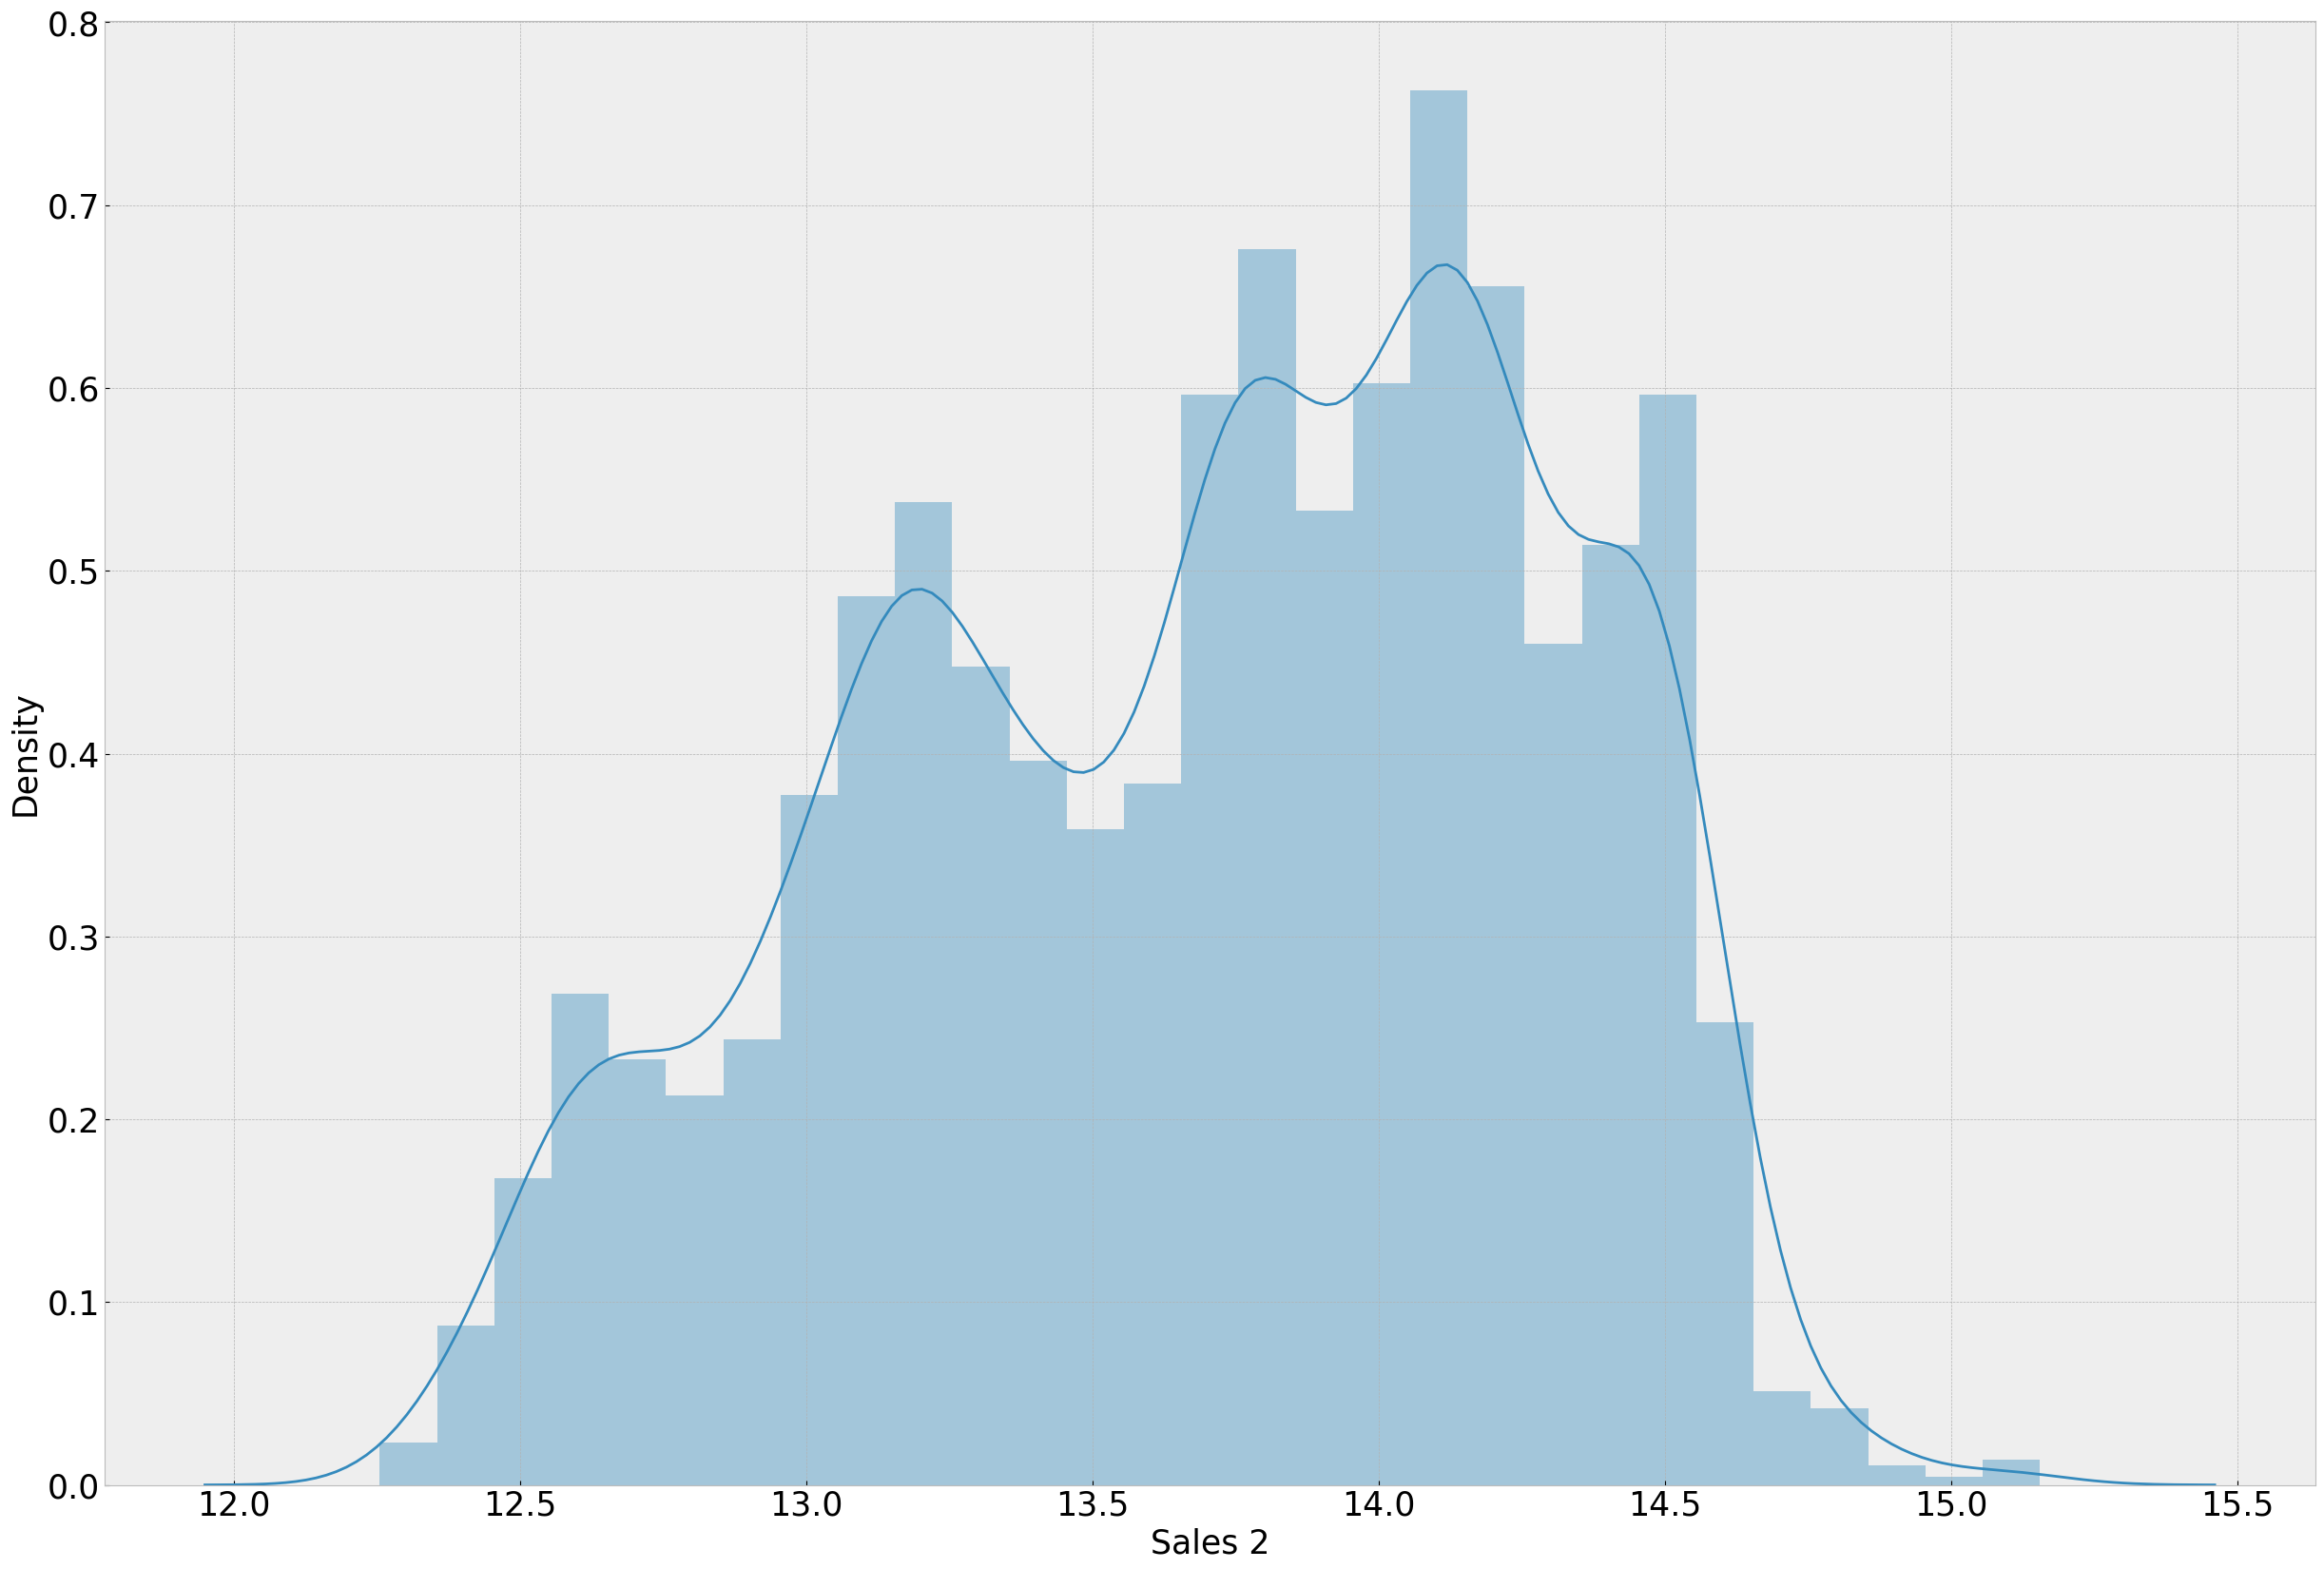

In [104]:
sns.distplot(df2['Sales 2']);

In [105]:
df = df2


In [106]:
df2['Sales'] = np.log1p(df2['Sales'])
df2.drop(columns='Sales 2', inplace =True)
df2

,Store,Date,Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
0,1,2010-02-05,14.312455,0,0.434149,0.050100,0.840500,0.405118,0.0,2,5
1,1,2010-02-12,14.311400,1,0.396967,0.038076,0.841941,0.405118,0.0,2,12
2,1,2010-02-19,14.292967,0,0.410861,0.021042,0.842405,0.405118,0.0,2,19
3,1,2010-02-26,14.158908,0,0.476419,0.044589,0.842707,0.405118,0.0,2,26
4,1,2010-03-05,14.256862,0,0.475147,0.076653,0.843008,0.405118,0.0,3,5
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,13.477482,0,0.654990,0.764028,0.651876,0.460514,1.0,9,28
6431,45,2012-10-05,13.505523,0,0.655088,0.758016,0.653427,0.458884,1.0,10,5
6432,45,2012-10-12,13.506898,0,0.553131,0.765531,0.654977,0.458884,1.0,10,12
6433,45,2012-10-19,13.484401,0,0.572701,0.750000,0.655013,0.458884,1.0,10,19


## 6 Feature Selection 

In [107]:
# first lets split our datasets into Train and Test
MinDate = df2['Date'][0]
MaxDate = df2['Date'][6434]

#df2['Date'].sort_values(ascending=False)[6434]
#df2[['Sales']] = np.expm1(df2[['Sales']])

split = MaxDate - MinDate
splitDate = split*0.75+MinDate

xtrain = df2[df2['Date']<splitDate]
ytrain = xtrain['Sales']

xtest = df2[df2['Date']>=splitDate]
ytest = xtest['Sales']

xtrain_n = xtrain.drop(columns=['Date','Sales'])

datas = df2[df2['Date']>=splitDate]


<Axes: xlabel='Date', ylabel='Sales'>

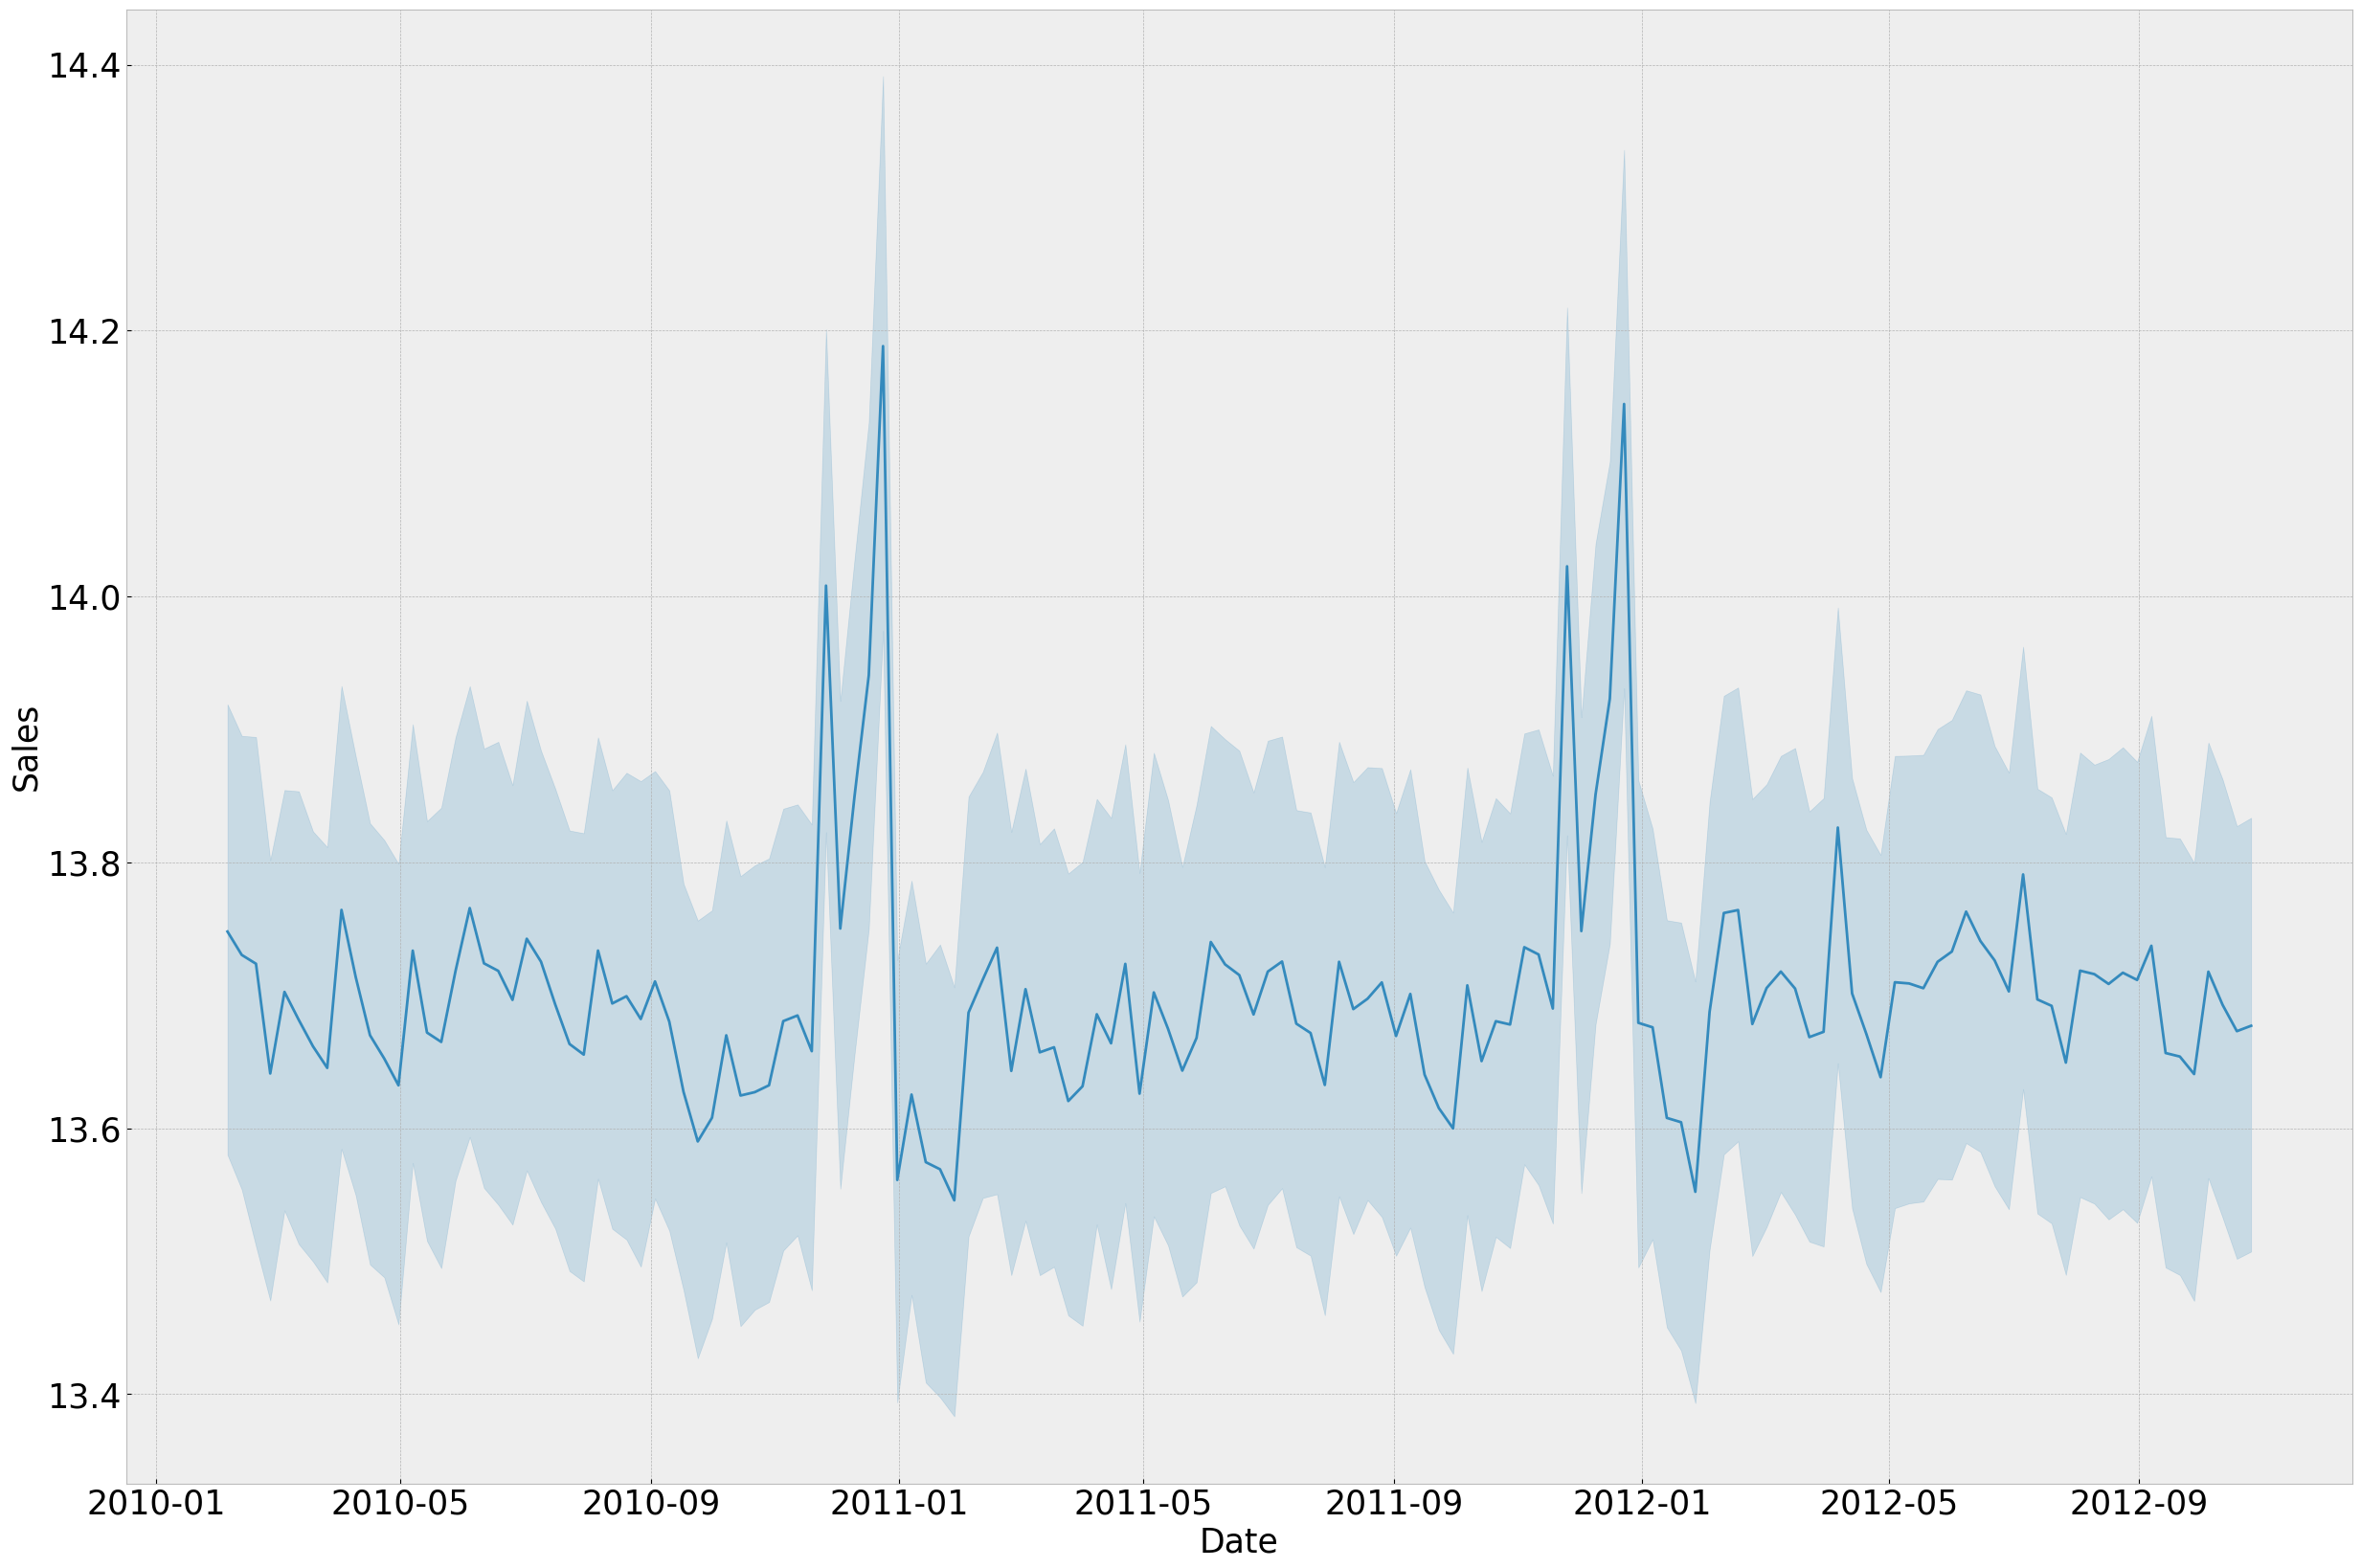

In [108]:
sns.lineplot(data=df2, x='Date',y='Sales')

In [109]:
df2['Sales 2'] = np.expm1(df2['Sales'])

In [110]:

rf = RandomForestRegressor(n_jobs=-1)

xtrain_n = xtrain_n.values
ytrain = ytrain.values.ravel()


In [111]:
boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(xtrain_n, ytrain)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	2


In [112]:
boruta.support_.tolist()
xtrain_boruta = xtrain.drop(columns=['Date','Sales'])


In [113]:
xtrain_boruta.columns[boruta.support_]

Index(['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month',
       'Day'],
      dtype='object')

In [114]:
#Segundo o Boruta, utilizando o metodo de Random Forest, identificamos que as features que fazem sentido para o modelo são:
cols_boruta = ['Store','Temperature','Fuel_Price','CPI','Unemployment','Month','Day']

In [115]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))
    

def ml_error( model_name, y, yhat):
    mae = mean_absolute_error(y, yhat) 
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt(mean_squared_error( y, yhat)) 
    
    return pd.DataFrame({'Model Name': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0])

In [116]:
aux1 = xtest.copy()
aux1['Sales'] = ytest.copy()

# Prediction
aux2 = aux1[['Store','Sales']].groupby('Store').mean().reset_index().rename( columns={'Sales':'Predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='Store')
yhat_baseline = aux1['Predictions']

# # Performance
baseline_result = ml_error( 'Average Model', np.expm1(ytest), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,52485.95875,1.042437,76675.551889


In [117]:
cols_boruta

['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Day']

In [118]:
xtrain = xtrain[cols_boruta]
xtest=xtest[cols_boruta]

### 7 Random Forest Regressor

In [119]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42).fit(xtrain, ytrain)

# Prediction
yhat_rf = rf.predict(xtest)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(ytest), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,134136.354708,0.134955,258347.195295


In [120]:
xtest.insert(7, "Predictions", yhat_rf)
xtest['Date'] = datas['Date']
xtest['Sales'] = ytest
xtest


,Store,Temperature,Fuel_Price,CPI,Unemployment,Month,Day,Predictions,Date,Sales
107,1,0.580333,0.542585,0.934803,0.332471,2,24,14.234819,2012-02-24,14.246896
108,1,0.616634,0.580160,0.936890,0.332471,3,2,14.361898,2012-03-02,14.339305
109,1,0.595108,0.599699,0.938977,0.332471,3,9,14.371344,2012-03-09,14.331582
110,1,0.653620,0.632265,0.940486,0.332471,3,16,14.355159,2012-03-16,14.332800
111,1,0.665264,0.658818,0.941223,0.332471,3,23,14.254787,2012-03-23,14.228328
...,...,...,...,...,...,...,...,...,...,...
6430,45,0.654990,0.764028,0.651876,0.460514,9,28,13.571807,2012-09-28,13.477482
6431,45,0.655088,0.758016,0.653427,0.458884,10,5,13.574161,2012-10-05,13.505523
6432,45,0.553131,0.765531,0.654977,0.458884,10,12,13.583561,2012-10-12,13.506898
6433,45,0.572701,0.750000,0.655013,0.458884,10,19,13.582031,2012-10-19,13.484401


<Axes: xlabel='Date', ylabel='Sales'>

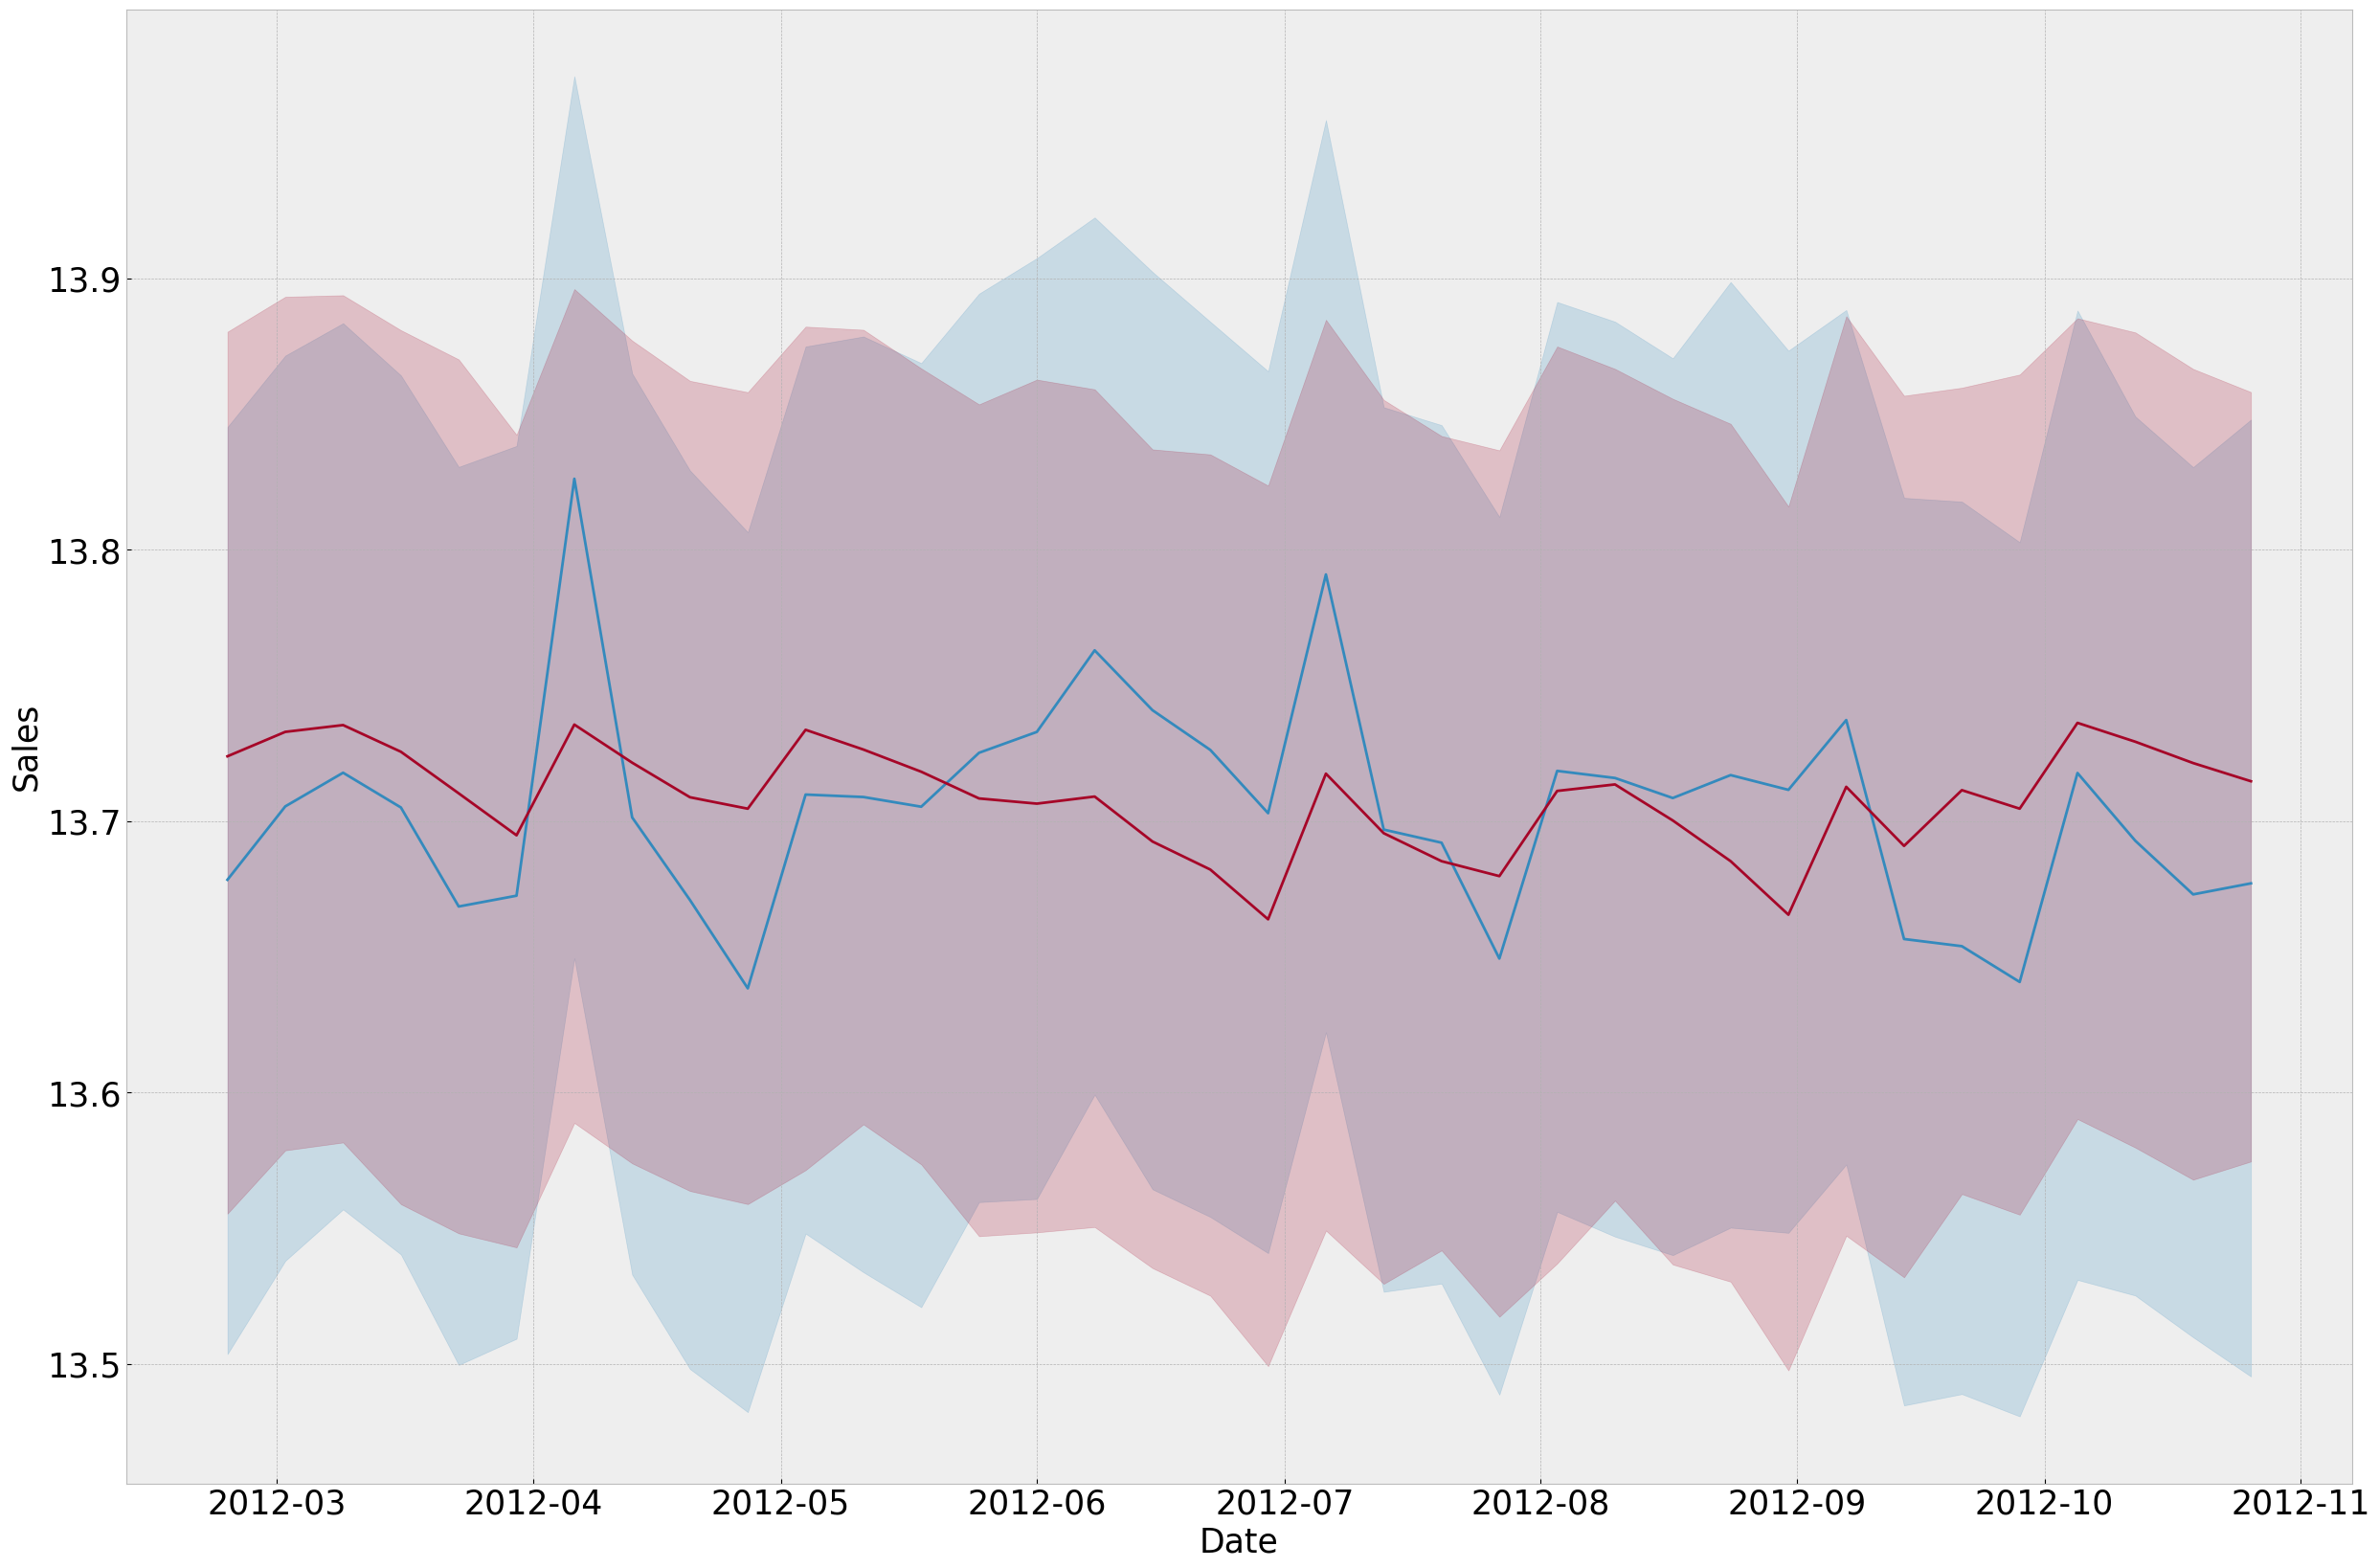

In [121]:
sns.lineplot(data=xtest, x='Date', y='Sales')
sns.lineplot(data=xtest, x='Date', y='Predictions')


### XGBoost Model

In [148]:
xtrain = xtrain[cols_boruta]
xtest=xtest[cols_boruta]

In [149]:
yhat_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=10,eta=0.1,subsample=0.7,colsample_bytree=1)
y_tnn_xgb = xgb.XGBRegressor(n_estimators=975, max_depth=50,eta=00.05,subsample=0.2,colsample_bytree=0.9)

In [150]:
yhat_xgb.fit(xtrain,ytrain)
y_tnn_xgb.fit(xtrain,ytrain)

yhat_xgb.score(xtrain,ytrain)
y_tnn_xgb.score(xtrain,ytrain)



0.9999689038022166

In [151]:
ypred = yhat_xgb.predict(xtest)
ypred_tnn = y_tnn_xgb.predict(xtest)


In [159]:
xtest['Predictions_XGB'] = np.expm1(ypred)
xtest['Sales'] = np.expm1(ytest)

In [160]:
xtest

,Store,Temperature,Fuel_Price,CPI,Unemployment,Month,Day,Predictions_XGB,Sales
107,1,0.580333,0.542585,0.934803,0.332471,2,24,1.534310e+06,1539387.83
108,1,0.616634,0.580160,0.936890,0.332471,3,2,1.660139e+06,1688420.76
109,1,0.595108,0.599699,0.938977,0.332471,3,9,1.697410e+06,1675431.16
110,1,0.653620,0.632265,0.940486,0.332471,3,16,1.655074e+06,1677472.78
111,1,0.665264,0.658818,0.941223,0.332471,3,23,1.543124e+06,1511068.07
...,...,...,...,...,...,...,...,...,...
6430,45,0.654990,0.764028,0.651876,0.460514,9,28,7.219508e+05,713173.95
6431,45,0.655088,0.758016,0.653427,0.458884,10,5,7.703398e+05,733455.07
6432,45,0.553131,0.765531,0.654977,0.458884,10,12,7.624724e+05,734464.36
6433,45,0.572701,0.750000,0.655013,0.458884,10,19,7.646804e+05,718125.53


<Axes: xlabel='Sales', ylabel='Predictions_XGB'>

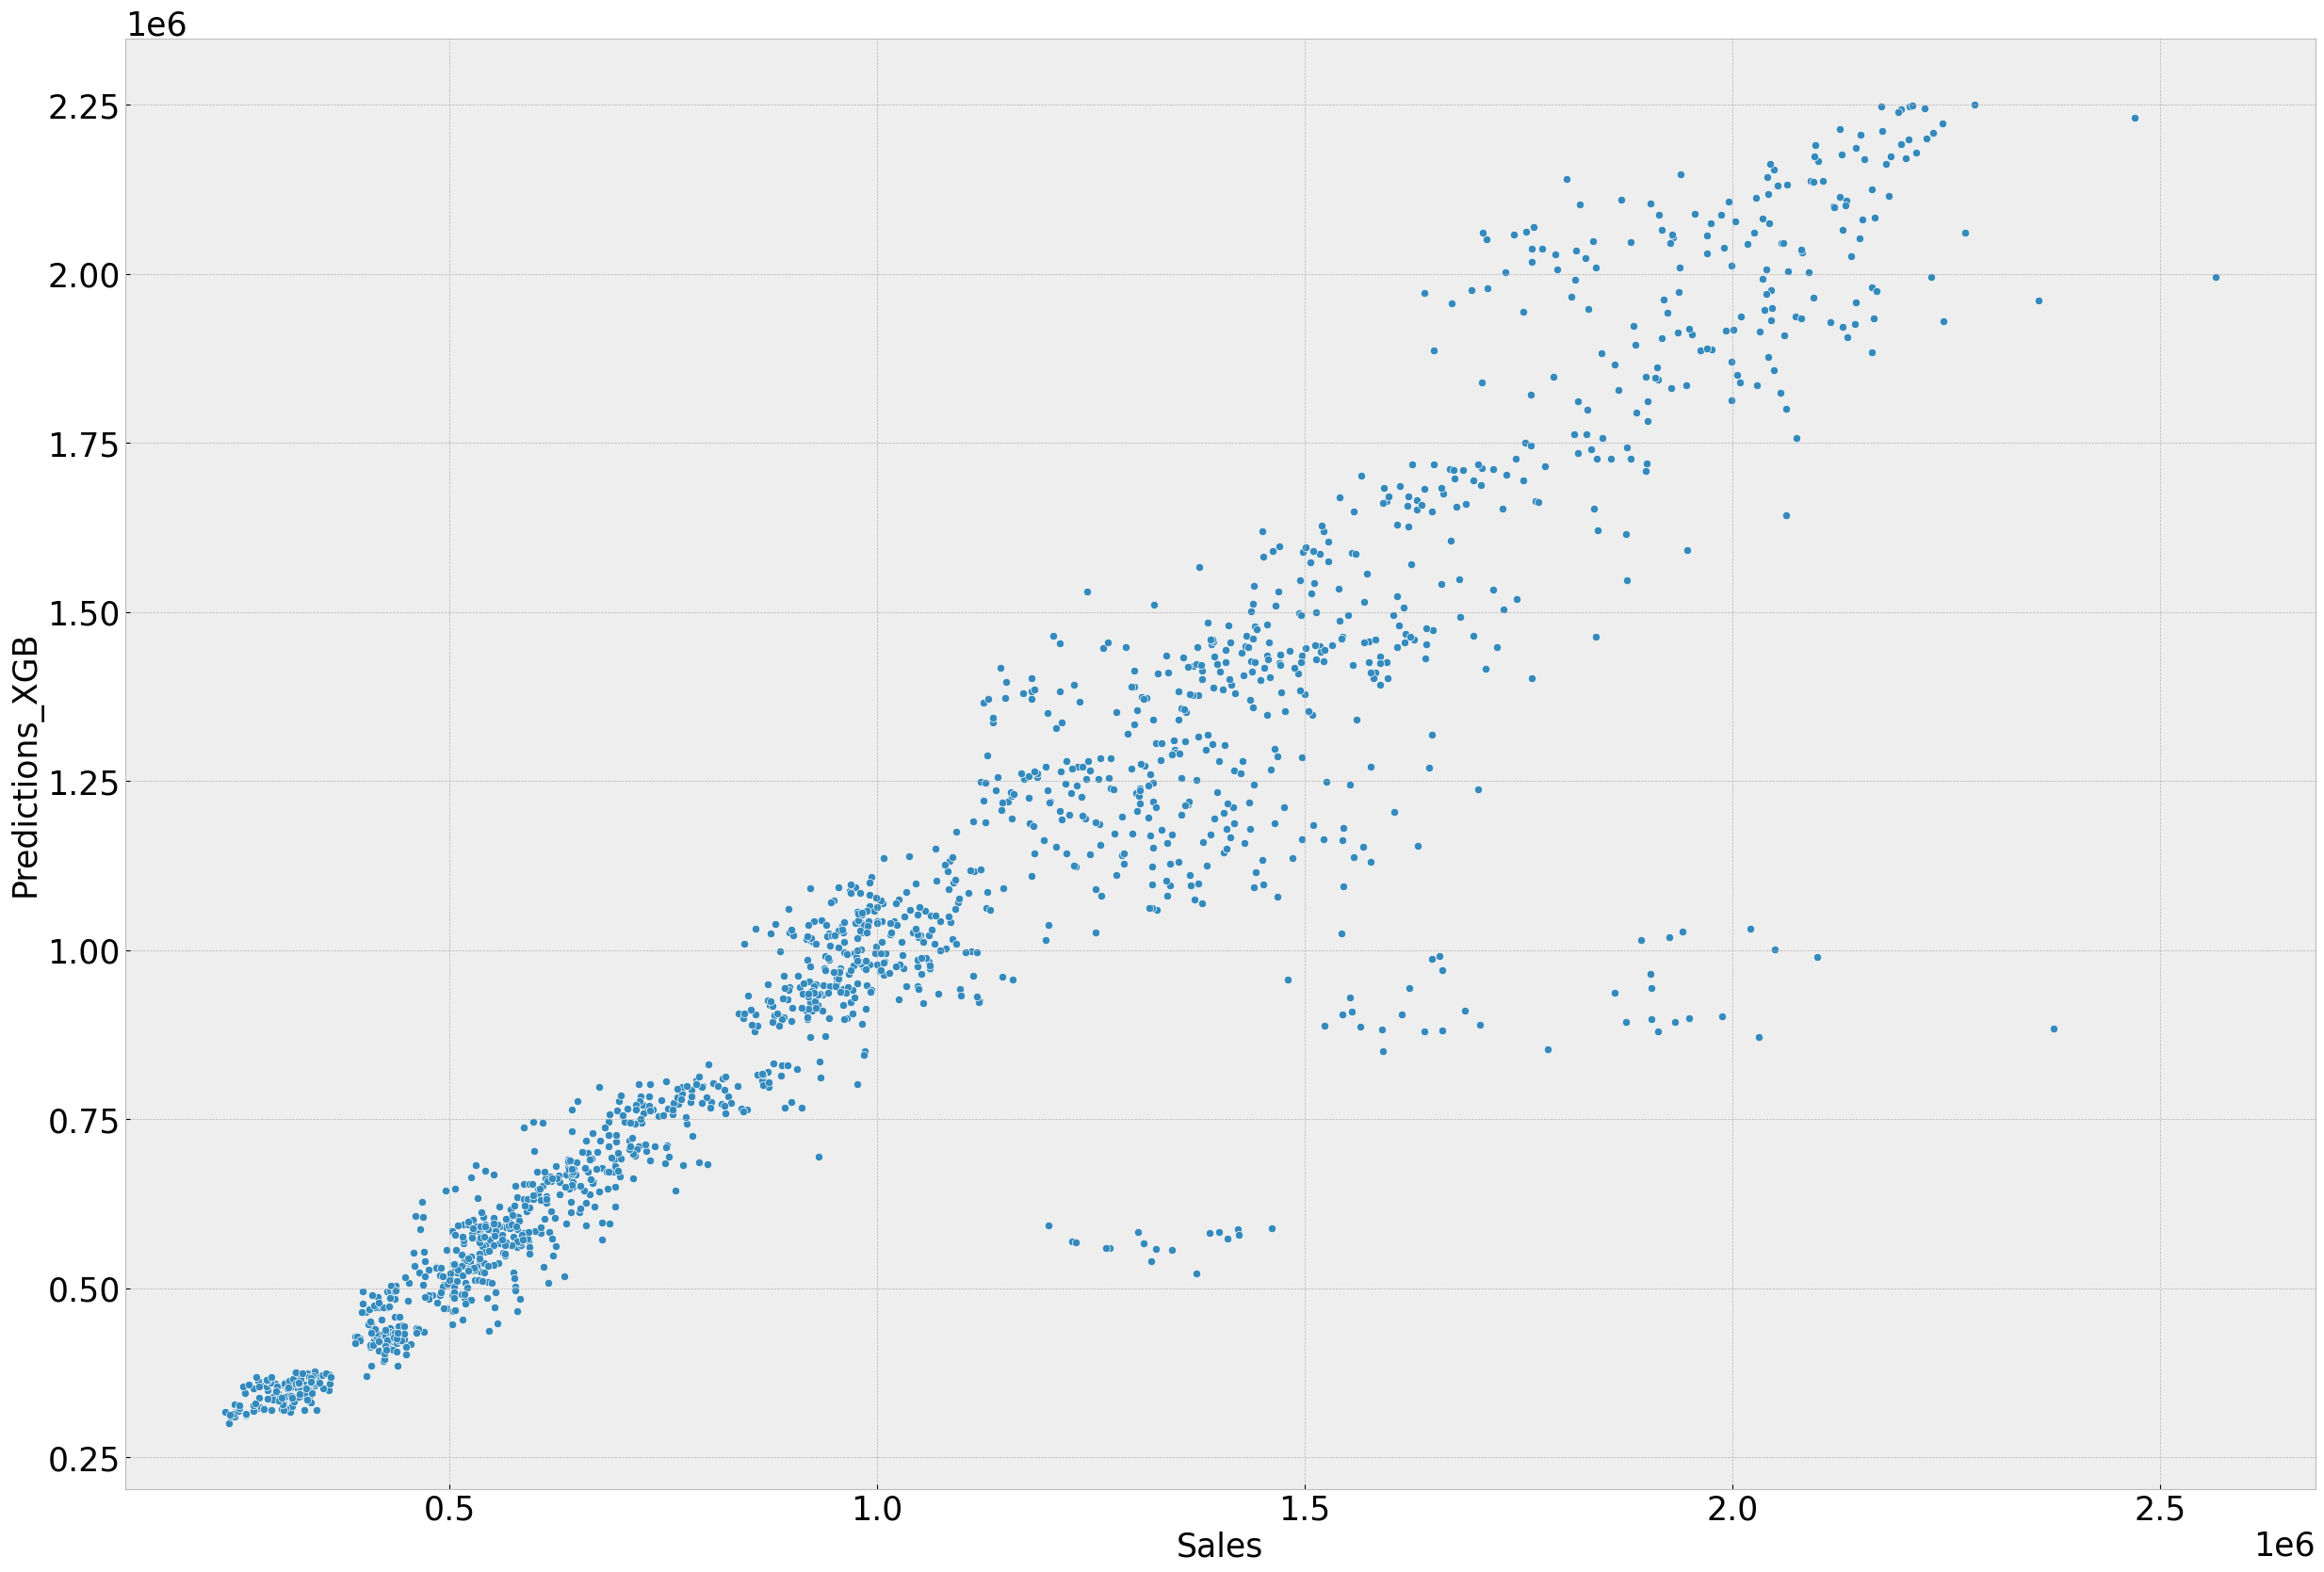

In [166]:
sns.scatterplot(data = xtest, x='Sales', y='Predictions_XGB')

In [127]:
xtest

,Store,Temperature,Fuel_Price,CPI,Unemployment,Month,Day,Predictions_XGB,Sales
107,1,0.580333,0.542585,0.934803,0.332471,2,24,1.534310e+06,1539387.83
108,1,0.616634,0.580160,0.936890,0.332471,3,2,1.660139e+06,1688420.76
109,1,0.595108,0.599699,0.938977,0.332471,3,9,1.697410e+06,1675431.16
110,1,0.653620,0.632265,0.940486,0.332471,3,16,1.655074e+06,1677472.78
111,1,0.665264,0.658818,0.941223,0.332471,3,23,1.543124e+06,1511068.07
...,...,...,...,...,...,...,...,...,...
6430,45,0.654990,0.764028,0.651876,0.460514,9,28,7.219508e+05,713173.95
6431,45,0.655088,0.758016,0.653427,0.458884,10,5,7.703398e+05,733455.07
6432,45,0.553131,0.765531,0.654977,0.458884,10,12,7.624724e+05,734464.36
6433,45,0.572701,0.750000,0.655013,0.458884,10,19,7.646804e+05,718125.53


<Axes: xlabel='Date', ylabel='Sales'>

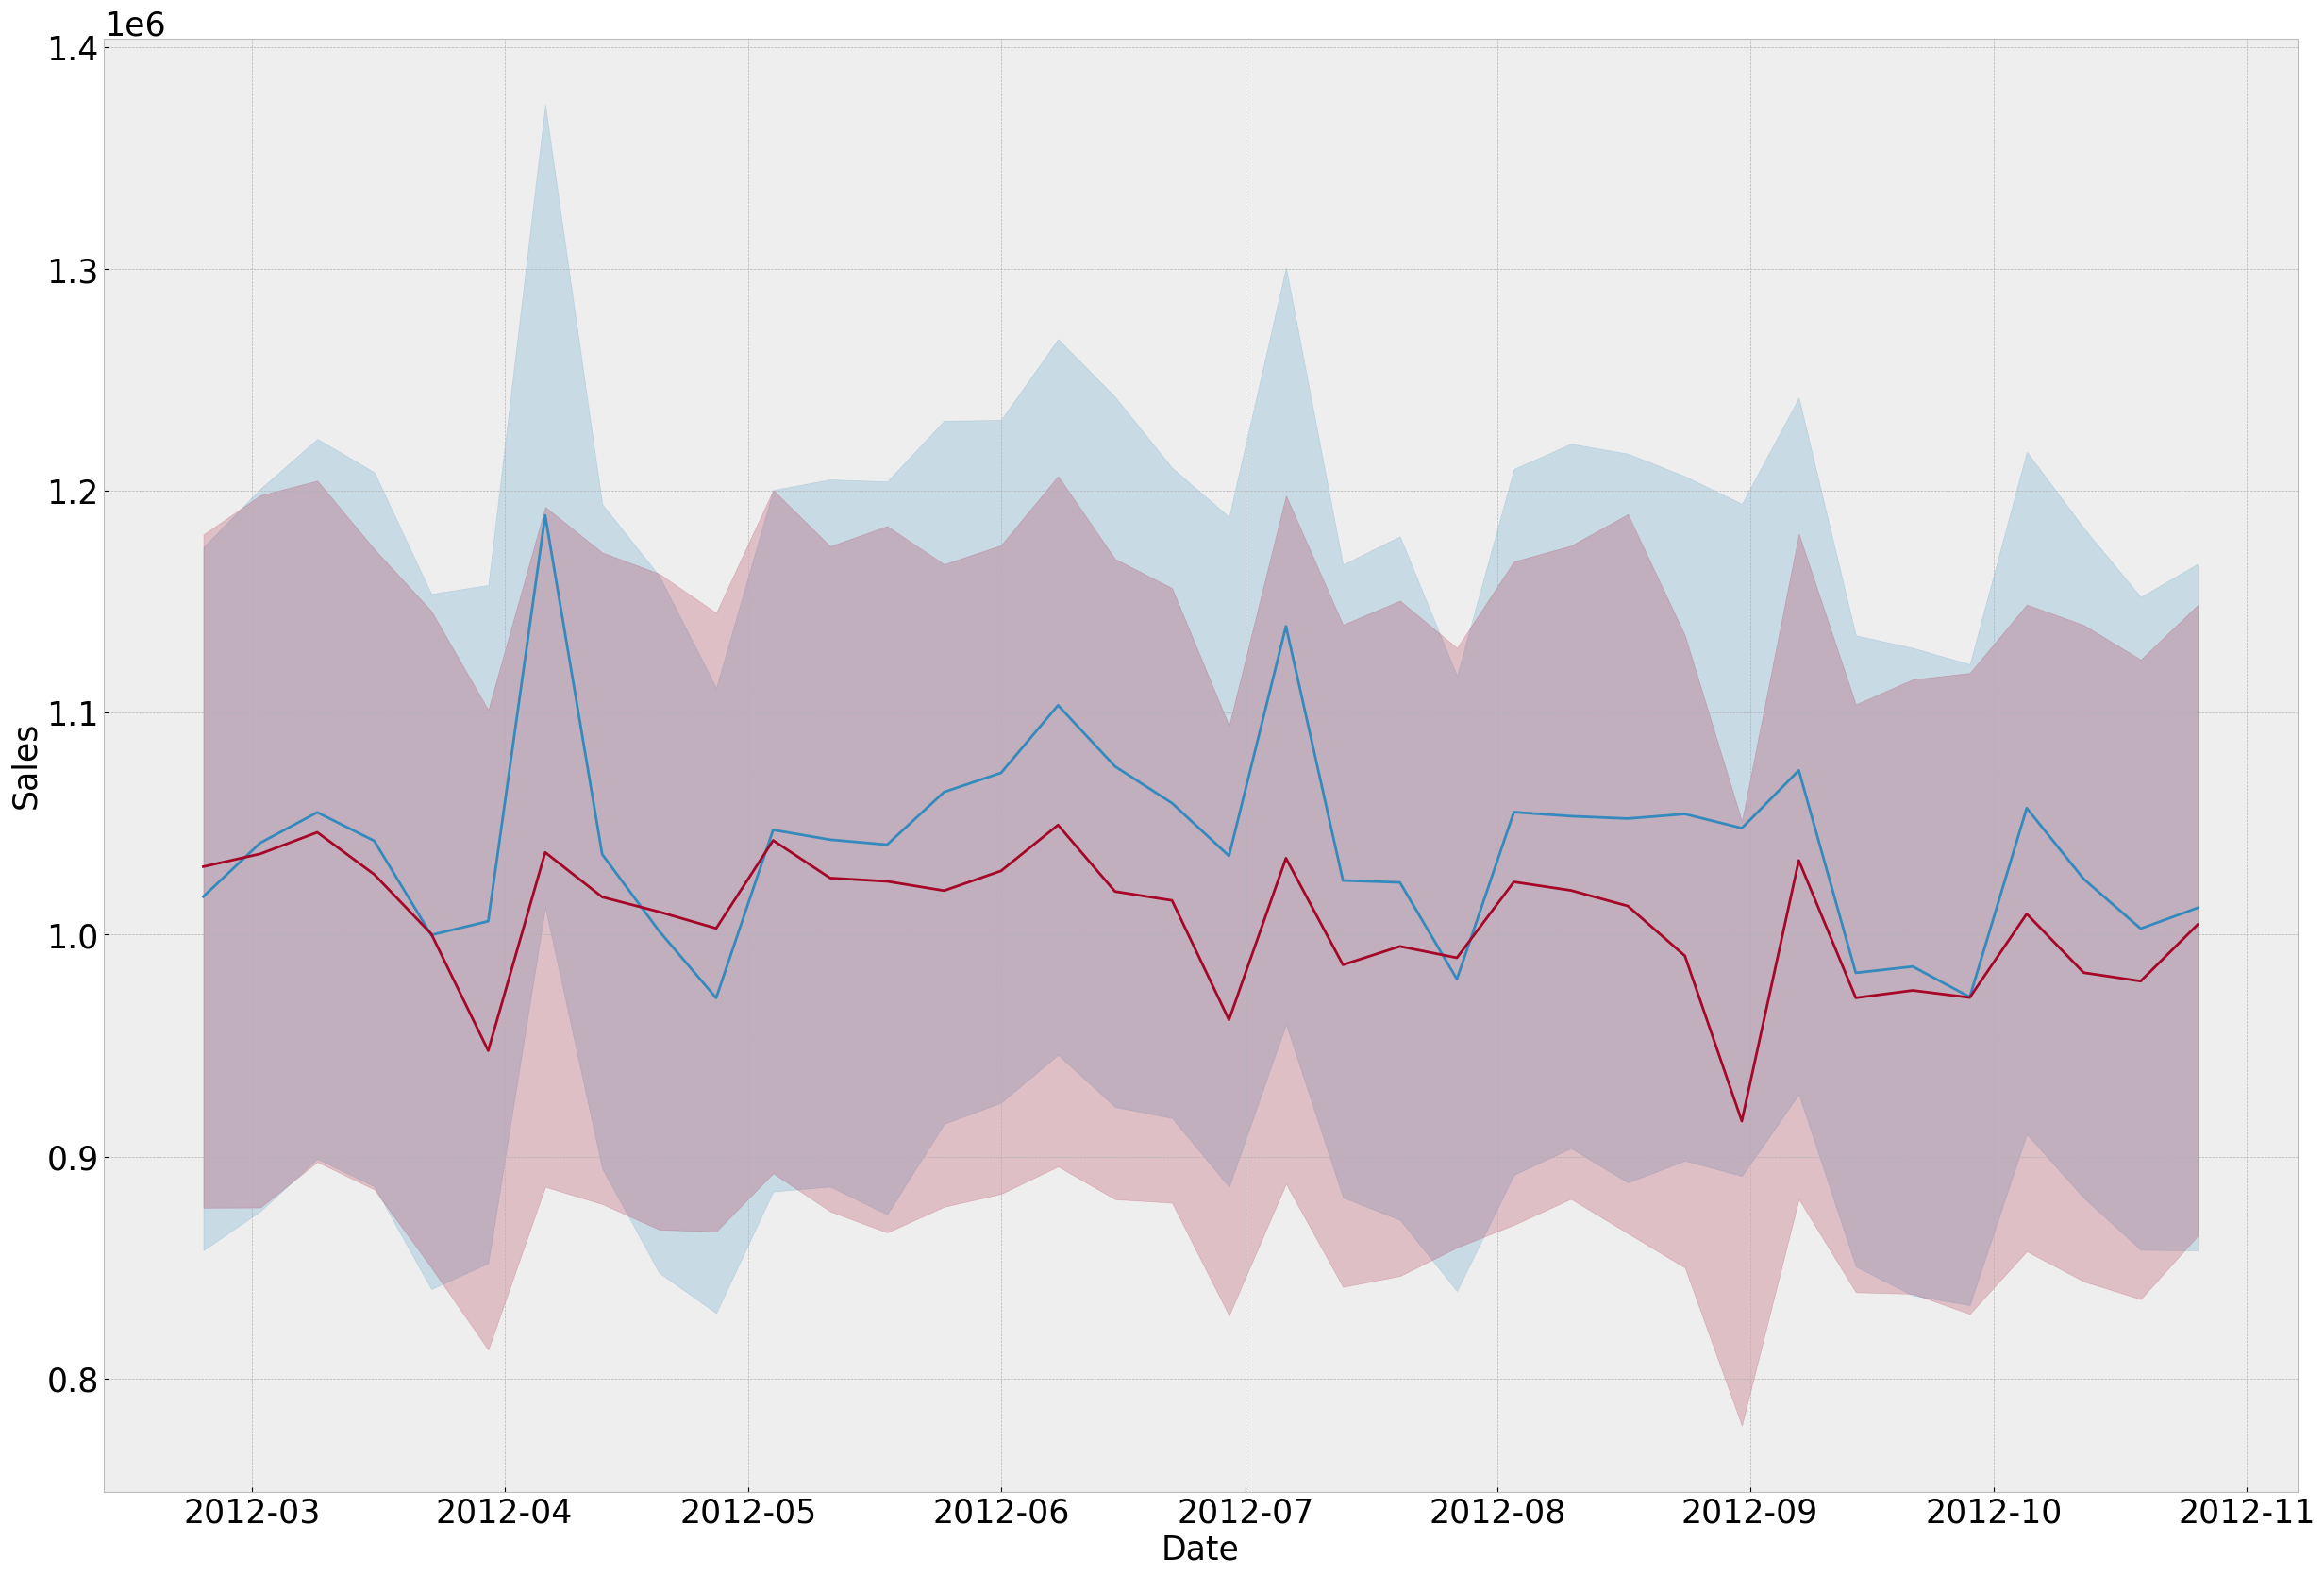

In [128]:
xtest['Date'] = datas['Date']
sns.lineplot(data=xtest, x='Date', y='Sales')
sns.lineplot(data=xtest, x='Date', y='Predictions_XGB')


In [129]:
ytest

107     14.246896
108     14.339305
109     14.331582
110     14.332800
111     14.228328
          ...    
6430    13.477482
6431    13.505523
6432    13.506898
6433    13.484401
6434    13.541445
Name: Sales, Length: 1620, dtype: float64

In [130]:
xgb_result = ml_error('XGBRegressor', np.expm1(ytest), np.expm1(ypred))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,96846.959291,0.08857,184757.107619


In [131]:
# Models Compare
modelling_result = pd.concat([rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,96846.959291,0.088570,184757.107619
0,Random Forest Regressor,134136.354708,0.134955,258347.195295


### TUNNING DOS PARAMETROS

In [132]:
param={
    "n_estimators" : np.arange(800,1200,25),
    "max_depth" : np.arange(0,80,5),
    "eta" : np.arange(0,0.8,0.05),
    "subsample" : np.arange(0,0.8,0.05),
    "colsample_bytree" : np.arange(0.2,1,0.05)
}


In [134]:
model = xgb.XGBRegressor()
#random_search = RandomizedSearchCV(model, param_distributions=param, n_iter = 7, scoring = 'roc_auc',n_jobs = -1,cv=5,verbose=3)

In [135]:
#start_time = datetime.now()
#random_search.fit(xtrain, ytrain)
#endtime = datetime.now()

In [136]:
#endtime - start_time

In [137]:
#random_search.best_params_

### Tradução e interpretação do erro

In [138]:
xtest['% Diff'] = ((xtest['Sales'] - xtest['Predictions_XGB'])/xtest['Sales'])*100

<Axes: xlabel='Date', ylabel='% Diff'>

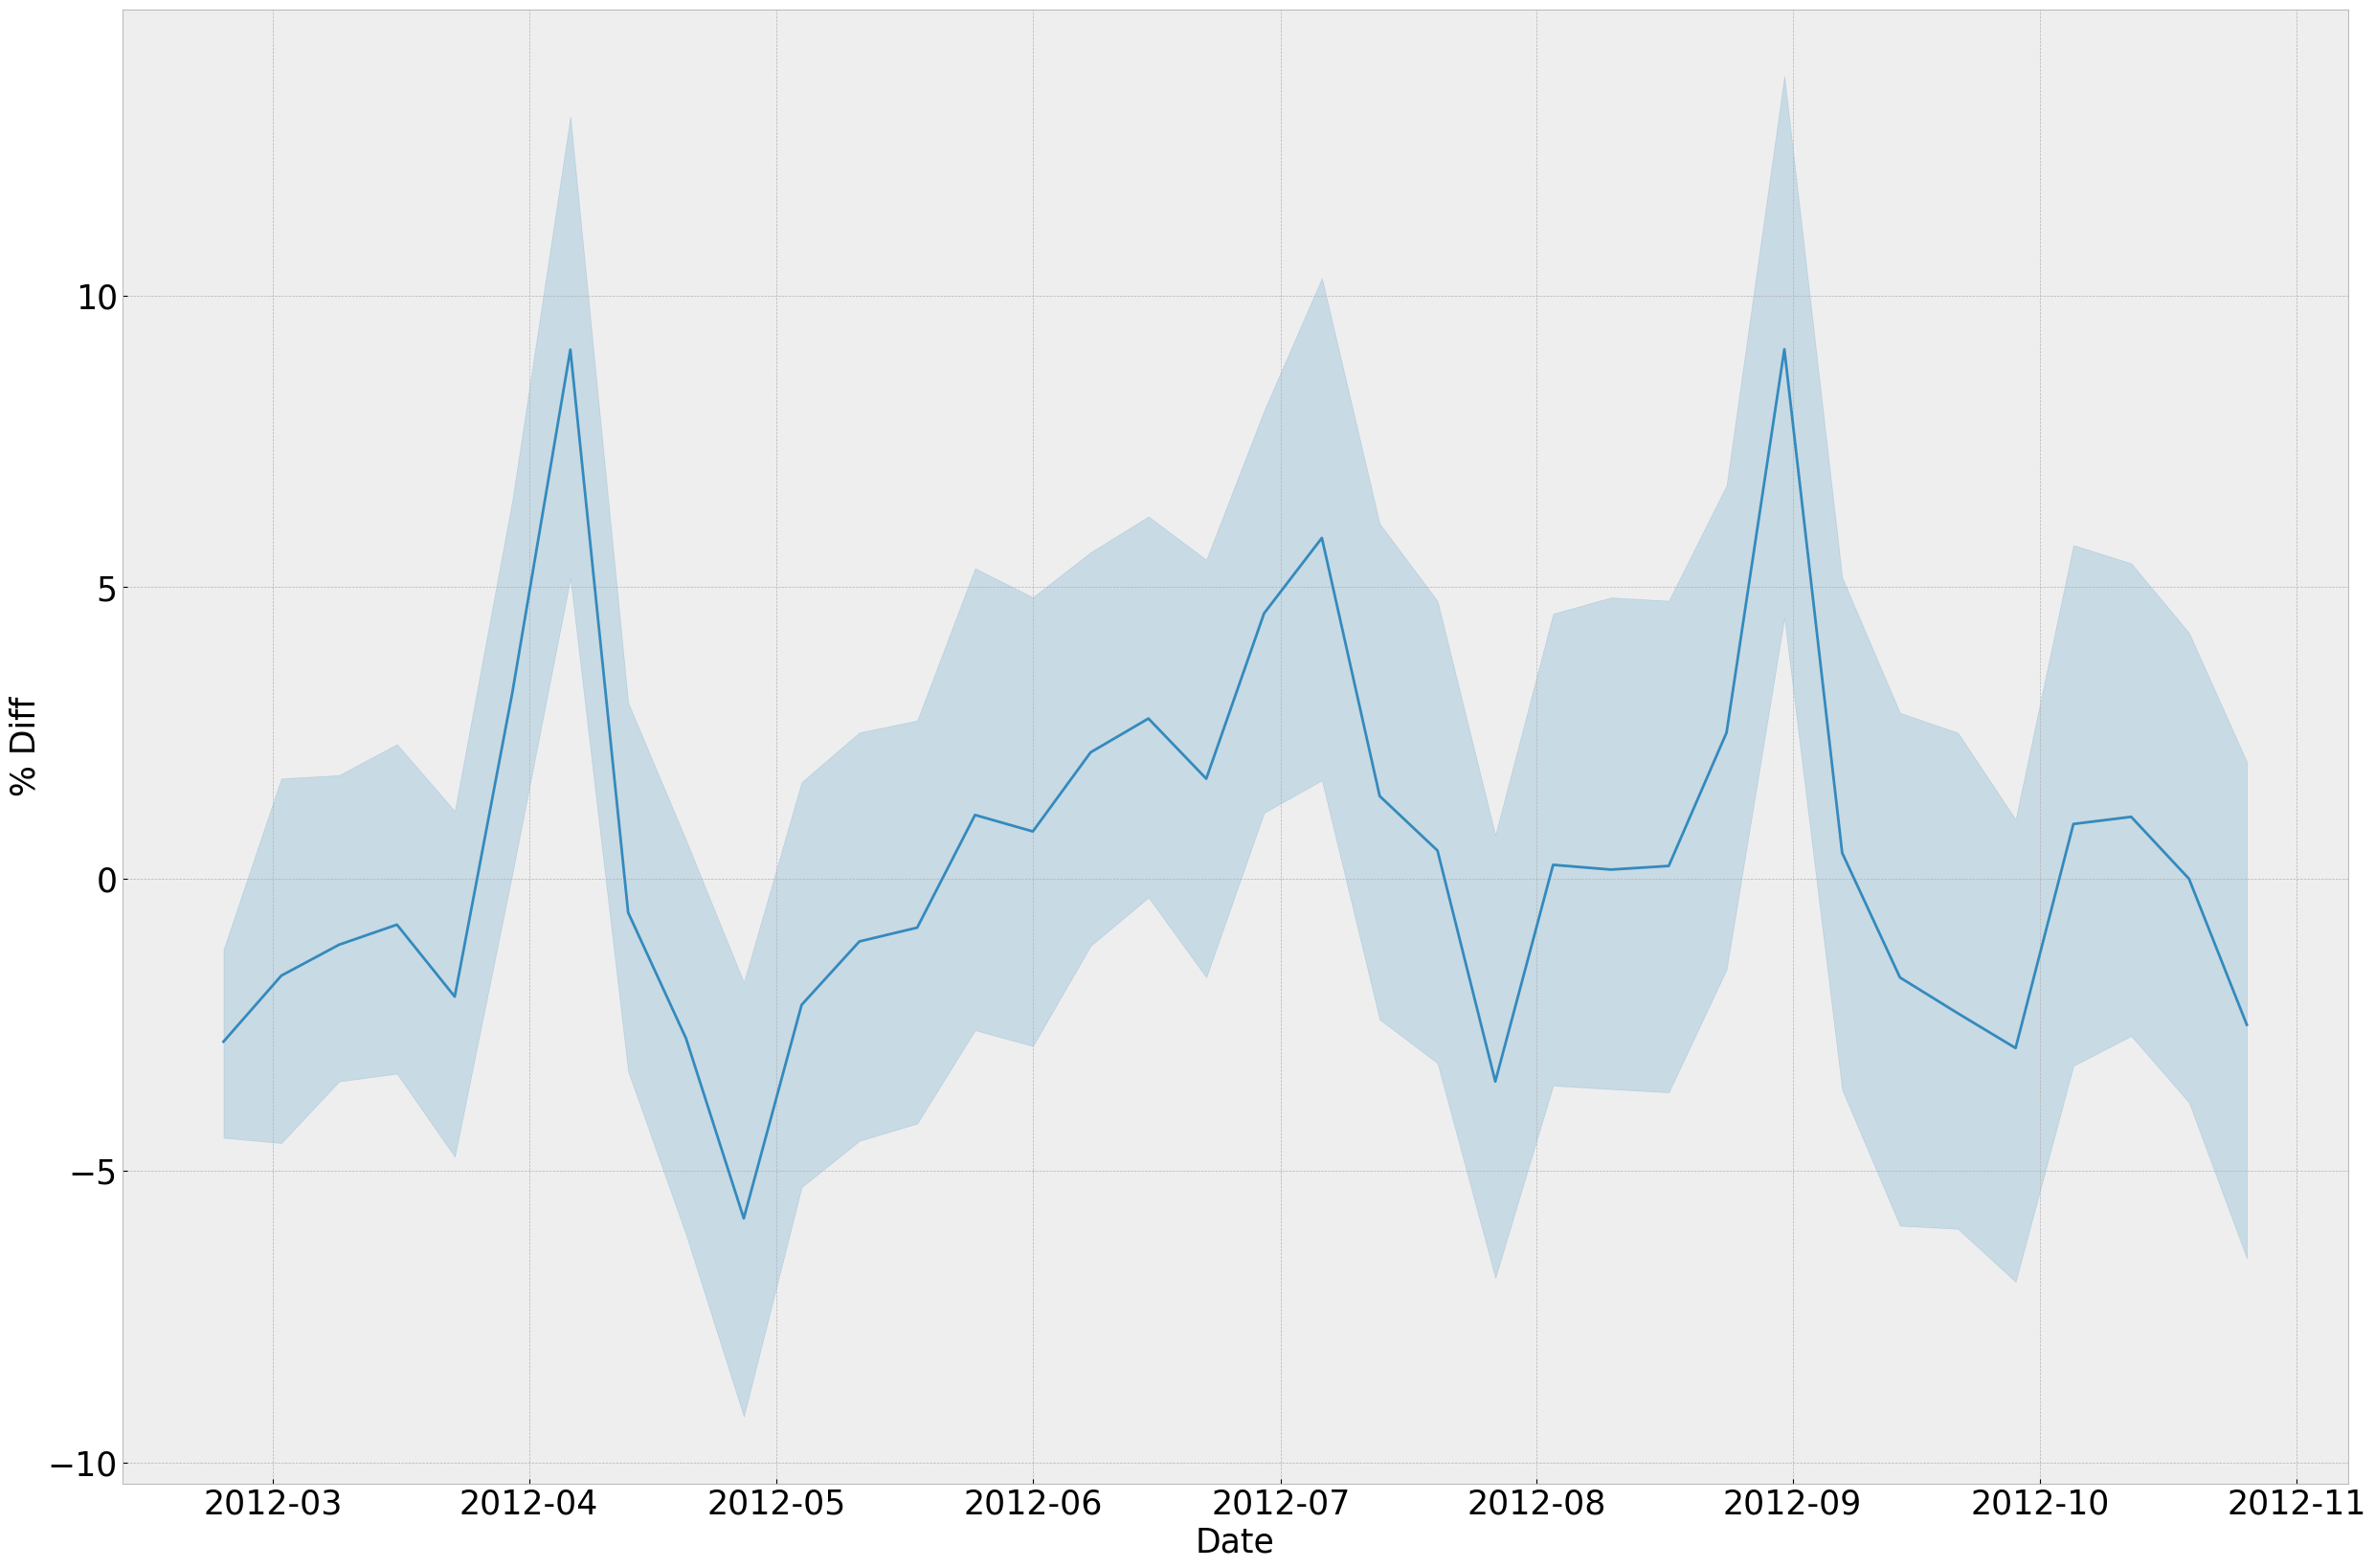

In [139]:
sns.lineplot(data=xtest, x='Date', y='% Diff')

In [140]:
xgb_result['MAE']

0    96846.959291
Name: MAE, dtype: float64

In [141]:
df3 = xtest
df3 = df3[['Store','Sales','Predictions_XGB']]

# MAE e MAPE
df_aux1 = df3[['Store', 'Sales', 'Predictions_XGB']].groupby('Store').apply(lambda x: mean_absolute_error(x['Sales'], x['Predictions_XGB'])).reset_index().rename(columns={0:'MAE'})
df_aux2 = df3[['Store', 'Sales', 'Predictions_XGB']].groupby('Store').apply(lambda x: mean_absolute_percentage_error(x['Sales'], x['Predictions_XGB'])).reset_index().rename(columns={0:'MAPE'})

df_aux3 = pd.merge(df_aux1,df_aux2, how='inner', on='Store')
df3 = pd.merge(df3, df_aux3, how='inner', on='Store')

# Scenarios
df3['worst_scenario'] = df3['Predictions_XGB'] - df3['MAE']
df3['best_scenario'] = df3['Predictions_XGB'] + df3['MAE']

In [142]:
df3['% Diff'] = ((df3['Sales'] - df3['Predictions_XGB'])/df3['Sales'])*100
df3 = df3.drop(columns=['MAE','MAPE','worst_scenario','best_scenario'])
df3

,Store,Sales,Predictions_XGB,% Diff
0,1,1539387.83,1.534310e+06,0.329836
1,1,1688420.76,1.660139e+06,1.675042
2,1,1675431.16,1.697410e+06,-1.311862
3,1,1677472.78,1.655074e+06,1.335269
4,1,1511068.07,1.543124e+06,-2.121400
...,...,...,...,...
1615,45,713173.95,7.219508e+05,-1.230676
1616,45,733455.07,7.703398e+05,-5.028903
1617,45,734464.36,7.624724e+05,-3.813402
1618,45,718125.53,7.646804e+05,-6.482828


In [143]:
df4 = df3[['Sales','Predictions_XGB','worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns= {'index': 'Scenario', 0: 'Values'})
df4['Values'] = df4['Values'].map('R${:,.2f}'.format)
df4

KeyError: "['worst_scenario', 'best_scenario'] not in index"

In [ ]:
df.drop(columns='Sales', inplace=True)